In [1]:
%load_ext autoreload
%autoreload 2

In [73]:
from saxs_data_processing import io, target_comparison, subtract

import matplotlib.pyplot as plt
import numpy as np

In [3]:
## Need to re-run all existing data here


## Load measurement data

In [25]:
bio_conf = 24
root_dirs = ['/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_15_Highlights_replicates/', 
             '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_11_randomV3_round2/', 
             '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_07_randomcampaignV3/data/', 
             '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_17_randomBaselineV4/data/', 
             '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_05_StoberRandomCampaignV2/', 
             '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_11_05_optimizationRound1/']

In [43]:
data, data_fps, _ = io.load_data_files_biocube(root_dirs, bio_conf)

/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/io.py:148: UserWarning: Duplicate UUID found for b8953350-d5ad-4c99-b929-ebfe8febd0df. Check your file naming
  warnings.warn(
/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/io.py:148: UserWarning: Duplicate UUID found for ea0d2ca6-8818-45f8-b5e3-04858133284a. Check your file naming
  warnings.warn(
/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/io.py:148: UserWarning: Duplicate UUID found for 0ec4dd81-7487-4689-96b9-b0f646a2047d. Check your file naming
  warnings.warn(


## Load backgrounds and map to measurement data

In [28]:
# map data to backgrounds
background_fps = ['/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_05_StoberRandomCampaignV2/03210_B9-T1_Ethanol_background__000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_07_randomcampaignV3/data/03218_D1-T1_Ethanol_background_1_000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_11_randomV3_round2/03289_H6-T2_EtOH_background_1_000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_15_Highlights_replicates/03357_D5-T2_Background_1_EtOH_000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_17_randomBaselineV4/data/03439_C1-T2_EtOH_1_000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_11_05_optimizationRound1/03533_F9-T1_Ethanol_background_1_000.dat']

# map root filepath to esaxs background
background_mapping = {}

for bcg_fp in background_fps:
    bkg_data = io.read_1D_data(bcg_fp)
    root_dir = '/'.join(bcg_fp.split('/')[:-1])
    background_mapping[root_dir] = bkg_data

In [29]:
uuid2bkg = {}
uuid2root = {}
for uuid_val, fp in data_fps.items():
    root_dir = '/'.join(fp.split('/')[:-1])
    bkg = background_mapping[root_dir]

    uuid2bkg[uuid_val] = bkg

## Subtract and clip measurements

In [63]:
subtracted_data = {}
for uuid_val, signal in data.items():
    background = uuid2bkg[uuid_val]
    subtracted = subtract.chop_subtract(signal[0], background[0])

    if subtracted is not None:
        if len(subtracted) < 10:
            subtracted = None

    subtracted_data[uuid_val] = subtracted
    

/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:129: UserWarning: Failed to find region of valid data (low q limit not found). Check that your sample scatters reasonably well
  warnings.warn(
/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:197: UserWarning: Issue during data selection, check data quality
  warnings.warn("Issue during data selection, check data quality")
/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:134: UserWarning: Insufficient data points in q range with scattering. Check data quality
  warnings.warn(


## calculate scattering distance metric

In [65]:
target_r_nm = 60
target_r_angs = target_r_nm*10
target_pdi = 0.08

sld_silica = 8.575
sld_etoh = 9.611

In [76]:
distances = {}

for uuid_val, data_val in subtracted_data.items():

    if data_val is None:
        continue
    else:
        q = data_val['q'].to_numpy()
    
        meas_I = data_val['I'].to_numpy()
    
        #calculate target scattering
        target_I = target_comparison.target_intensities(q, target_r_angs, target_pdi, sld_silica, sld_etoh)
    
        distance = target_comparison.calculate_distance_powerlawscreen(data_val, target_I)
    
        distances[uuid_val] = distance




        

## Plot sorted results

In [77]:
uuids = np.array(list(distances.keys()))
rmses = list(distances.values())
uuid_sorted = uuids[np.argsort(rmses)]

/tmp/ipykernel_24061/1372462537.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


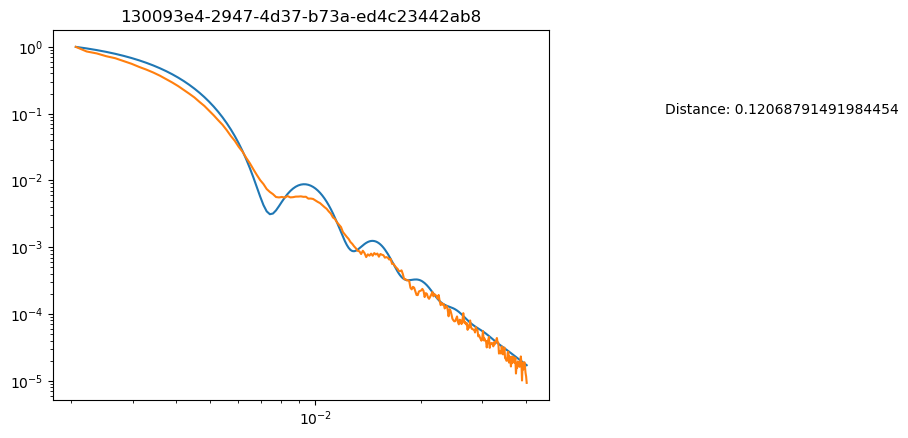

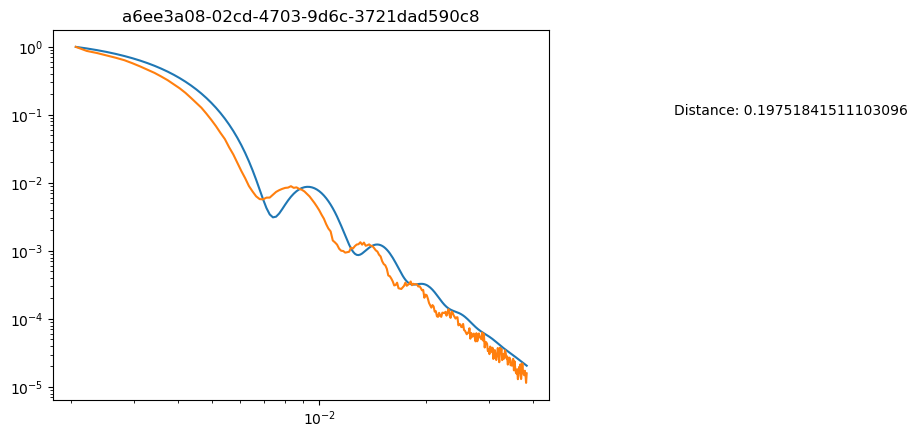

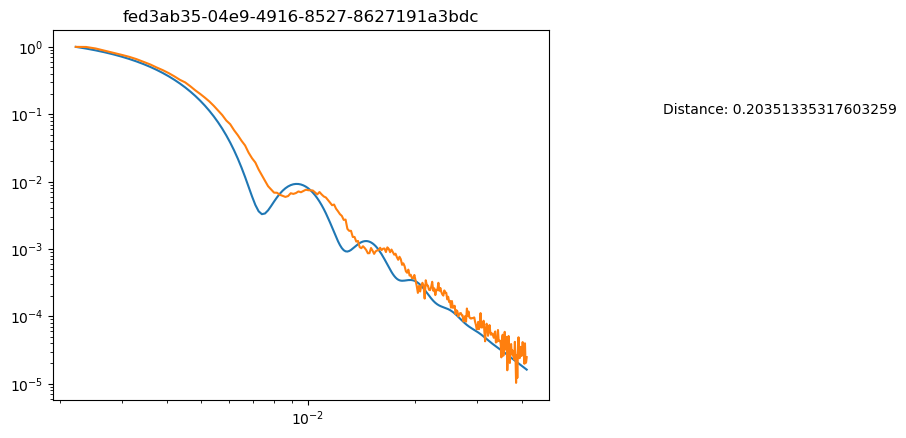

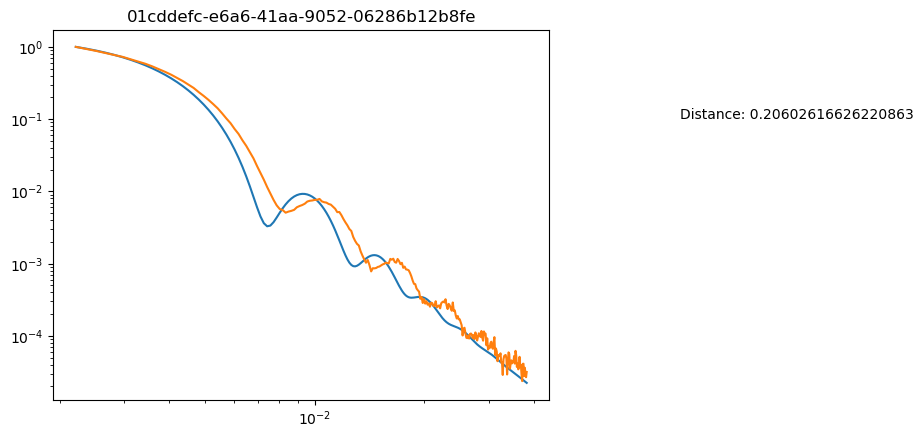

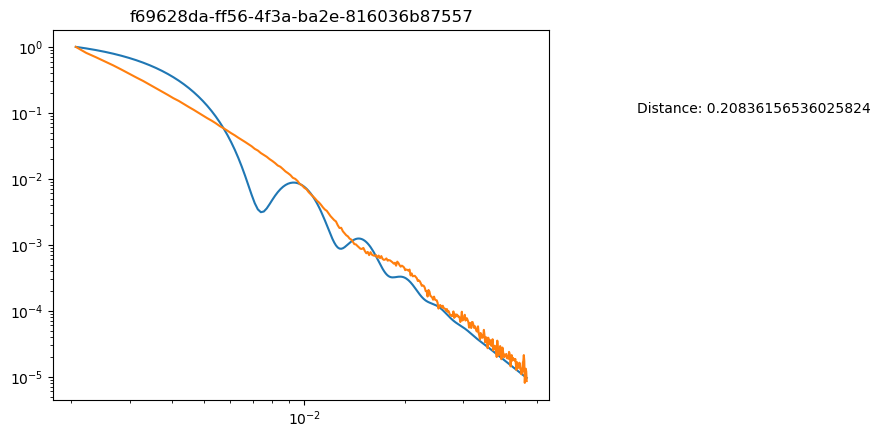

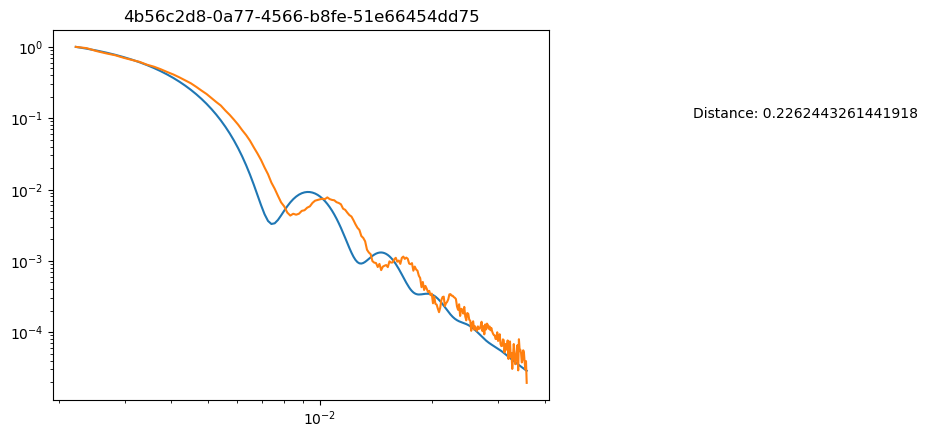

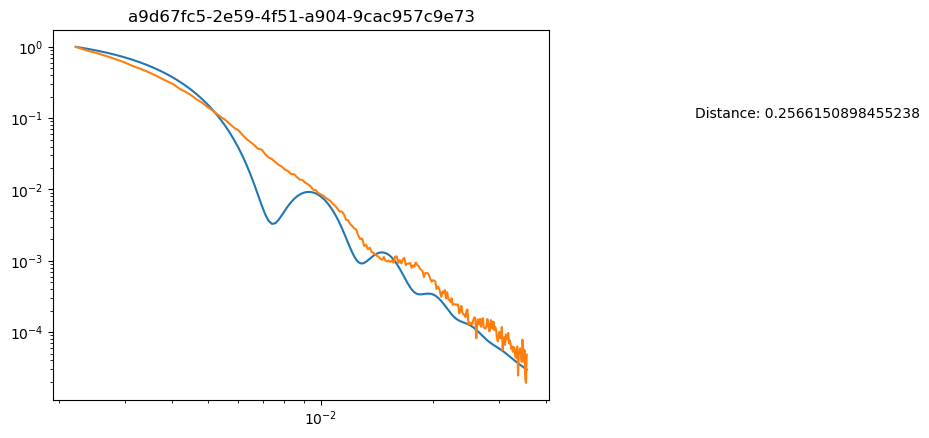

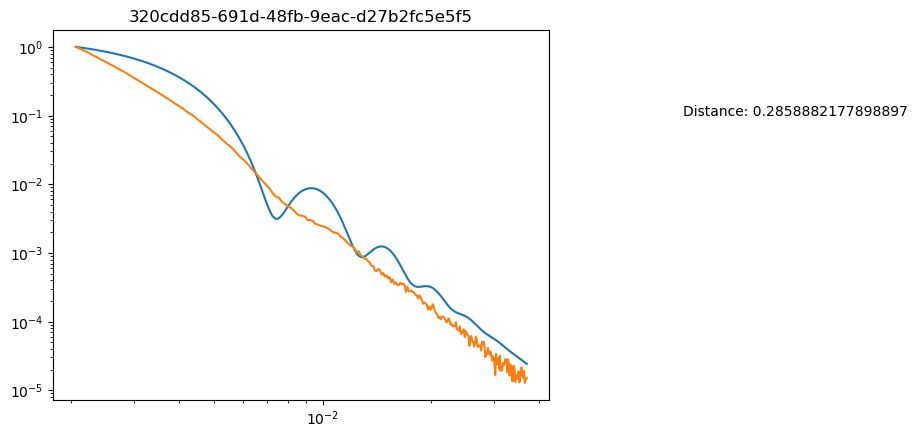

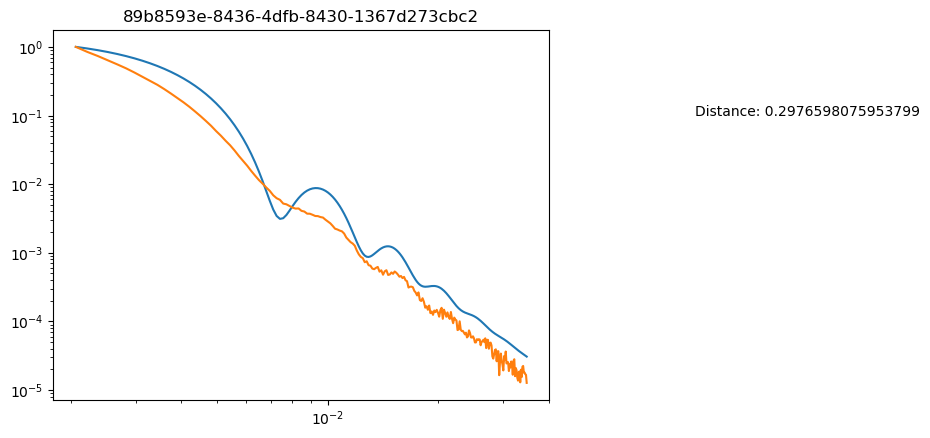

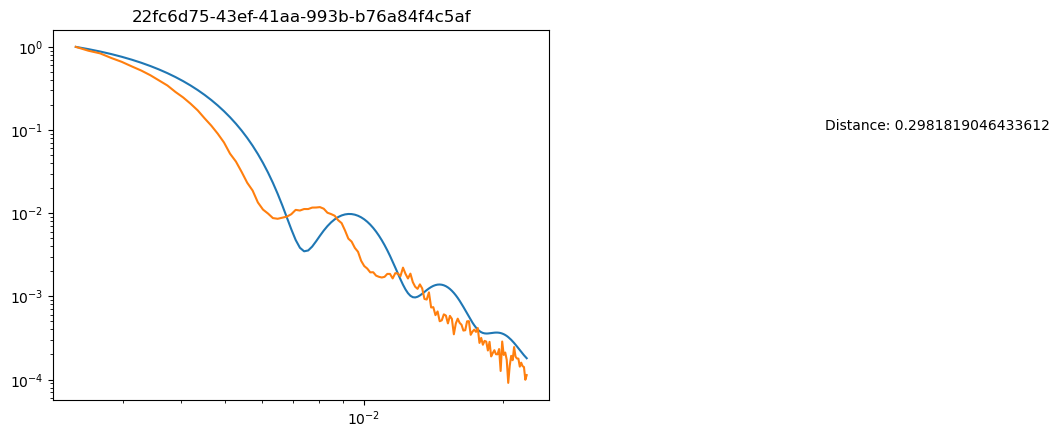

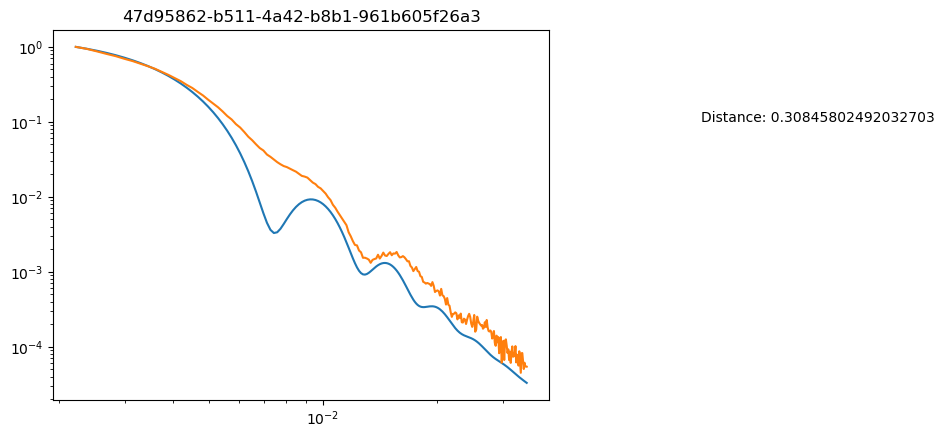

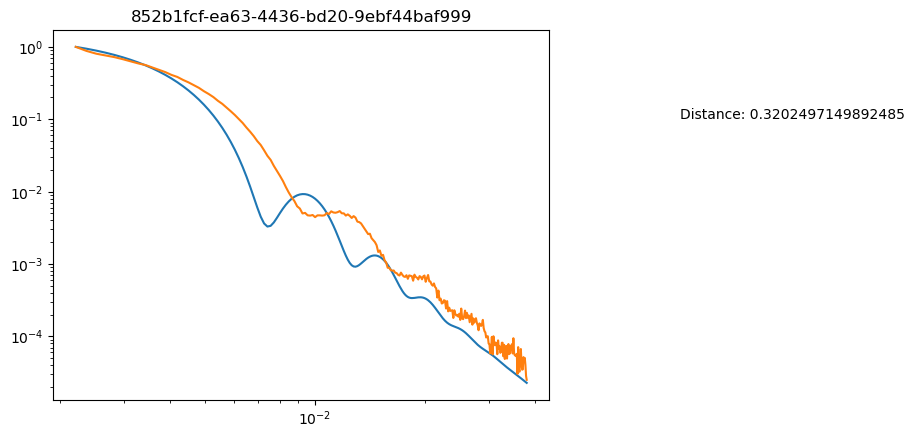

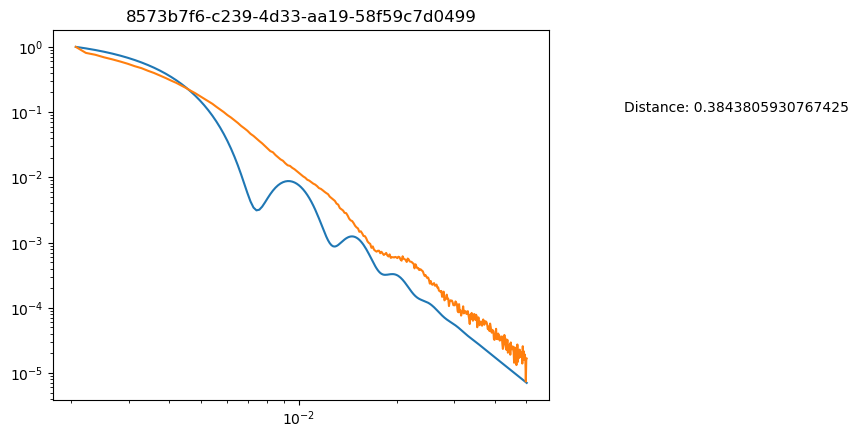

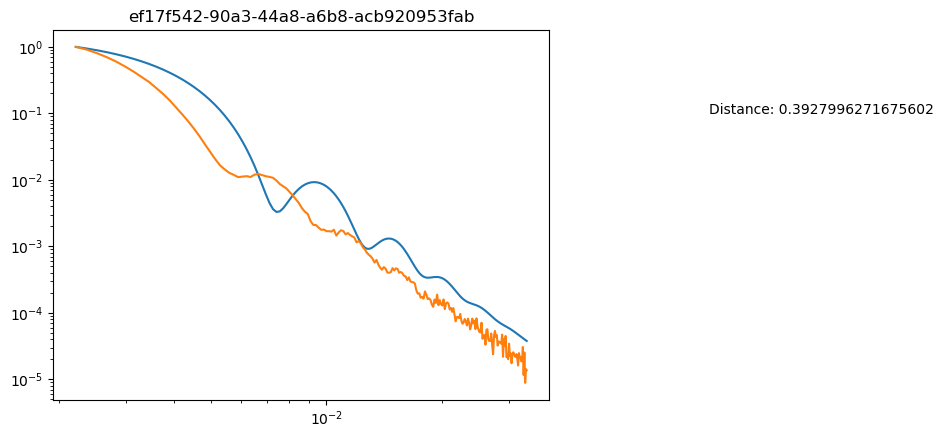

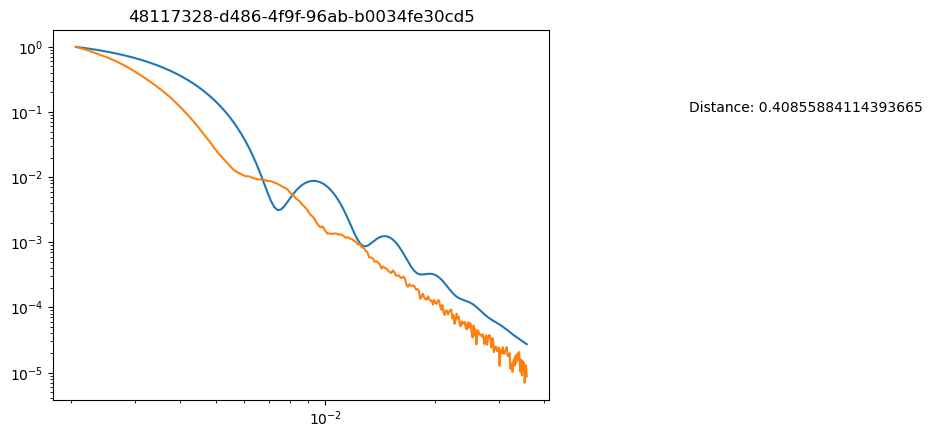

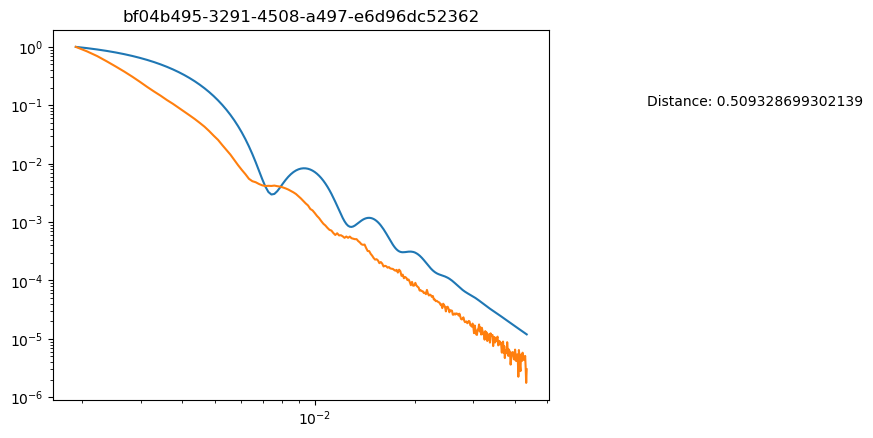

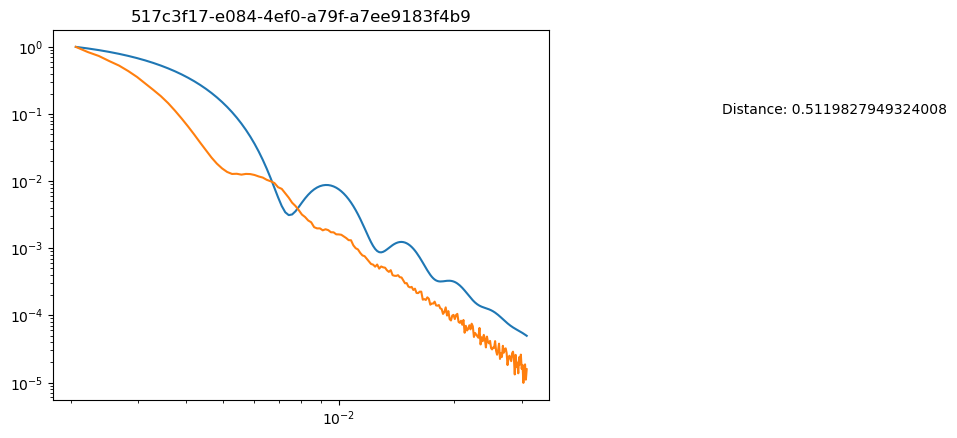

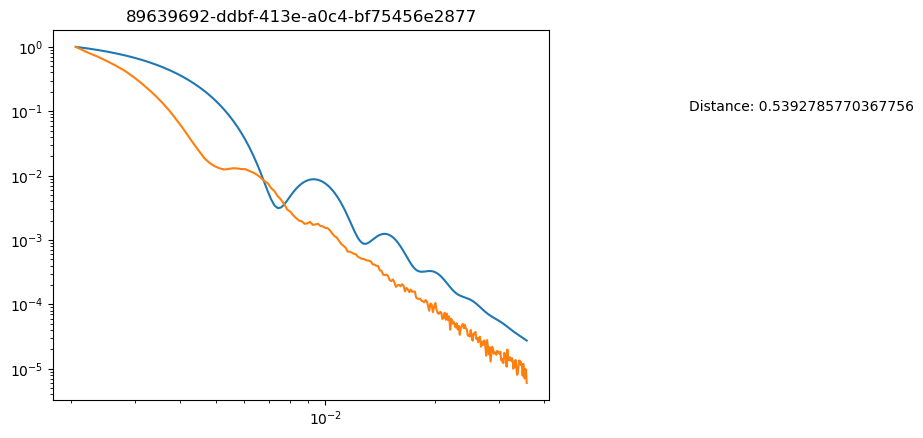

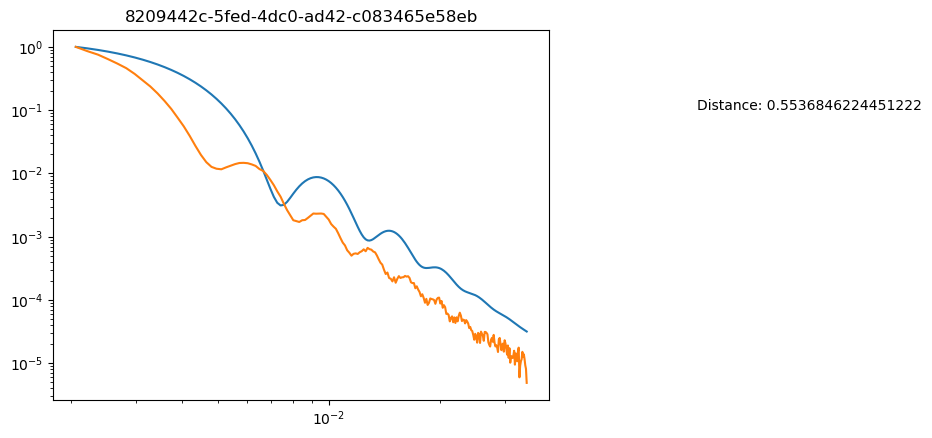

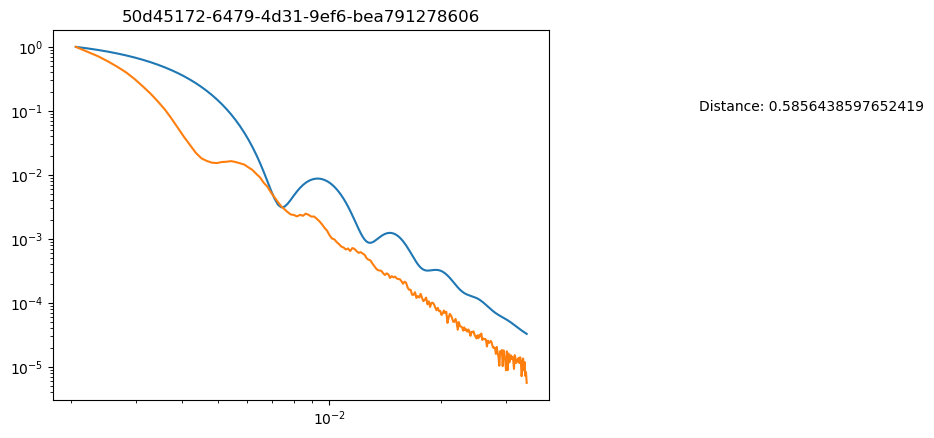

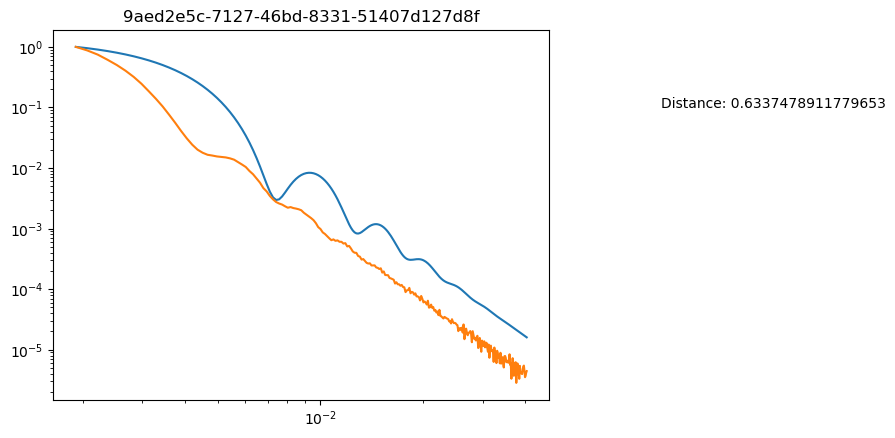

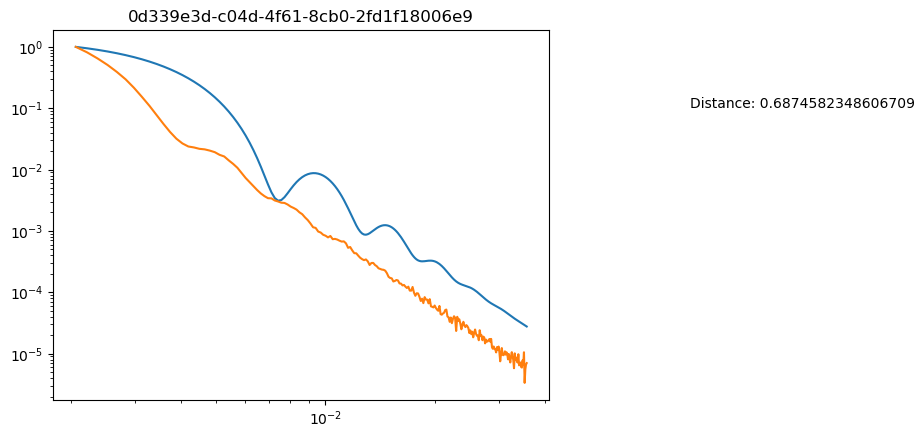

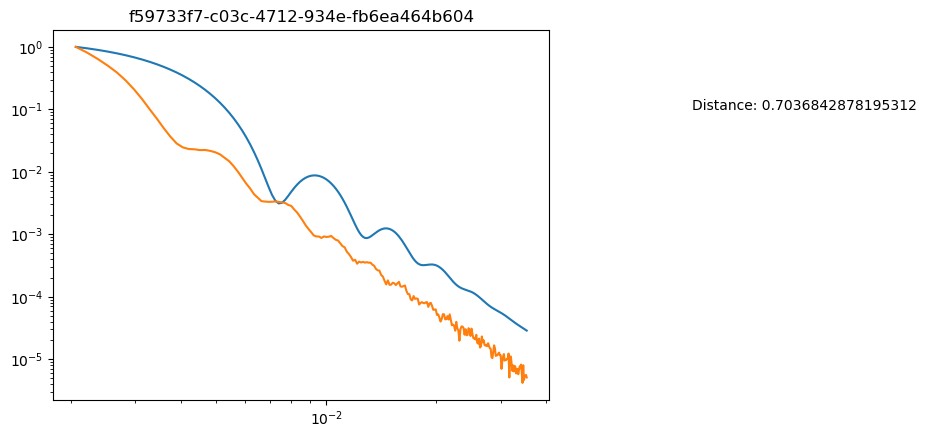

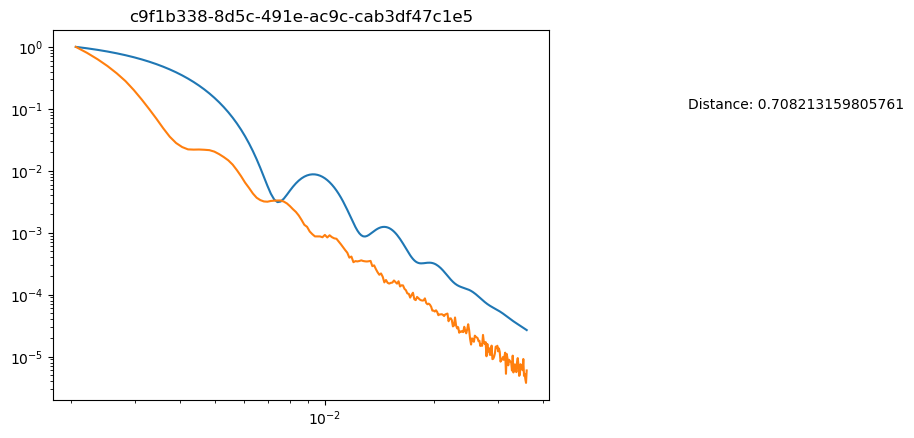

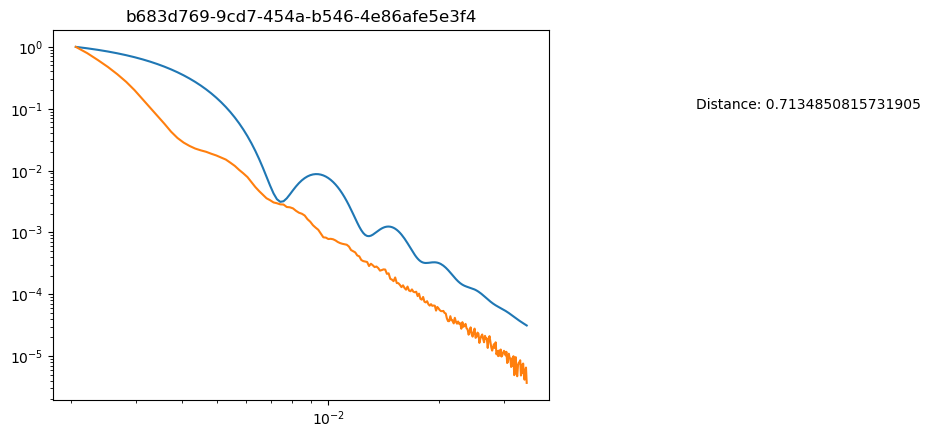

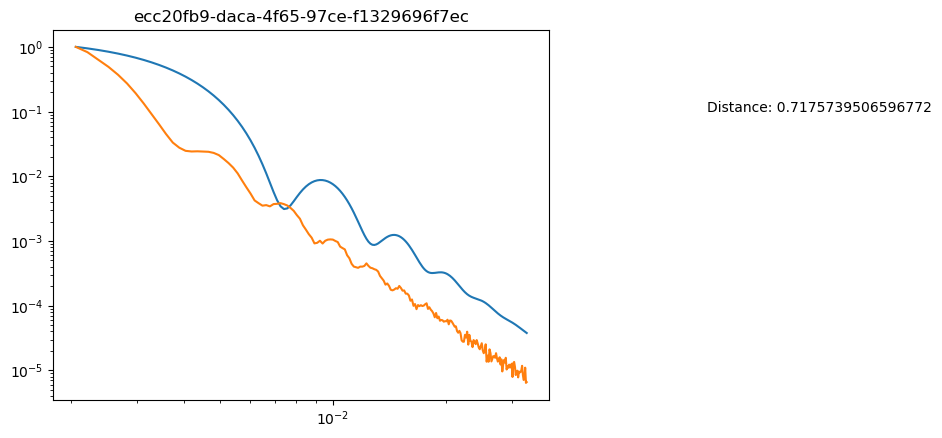

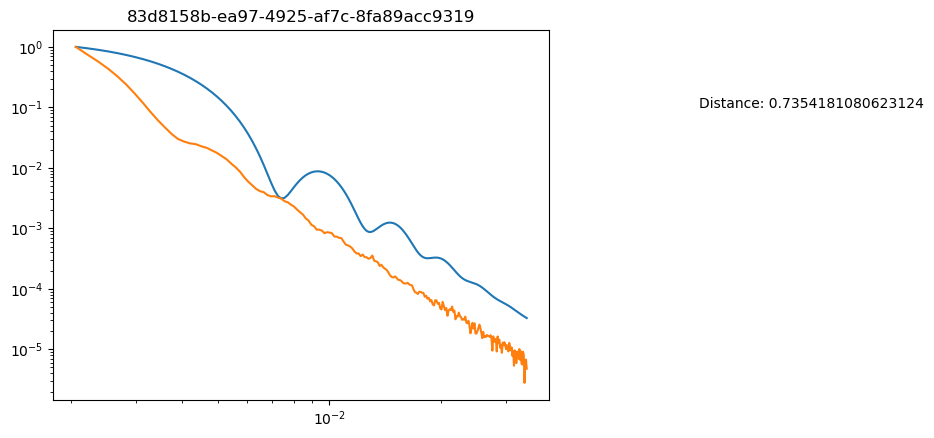

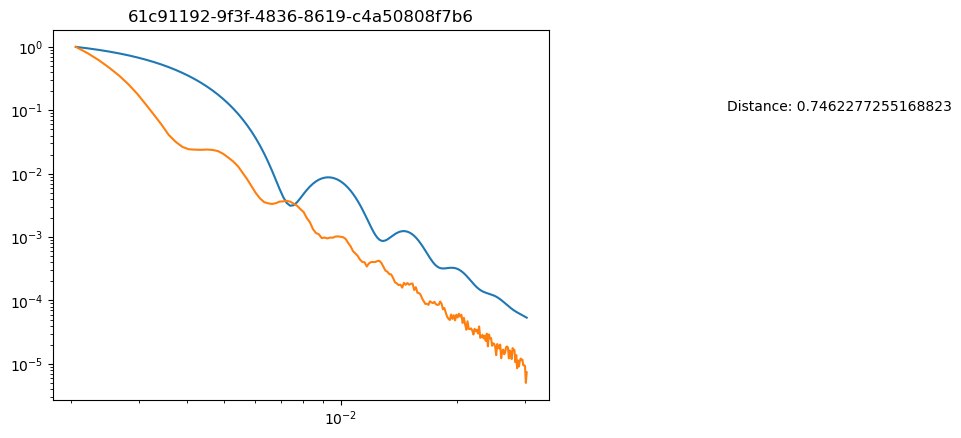

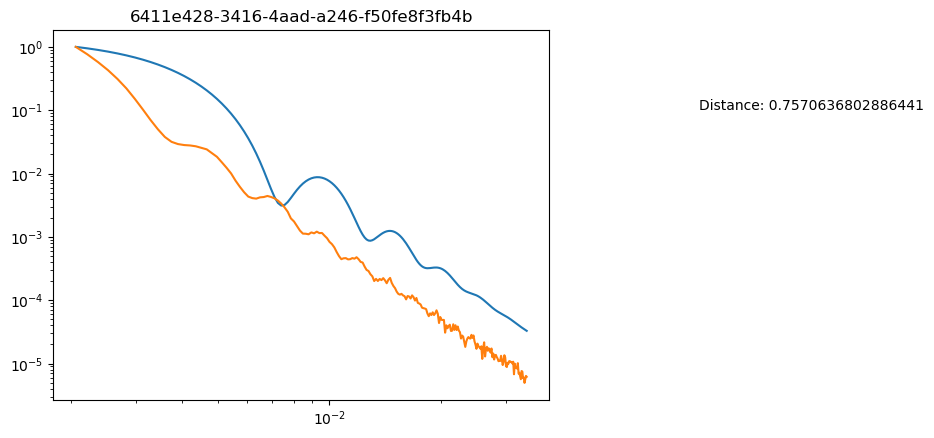

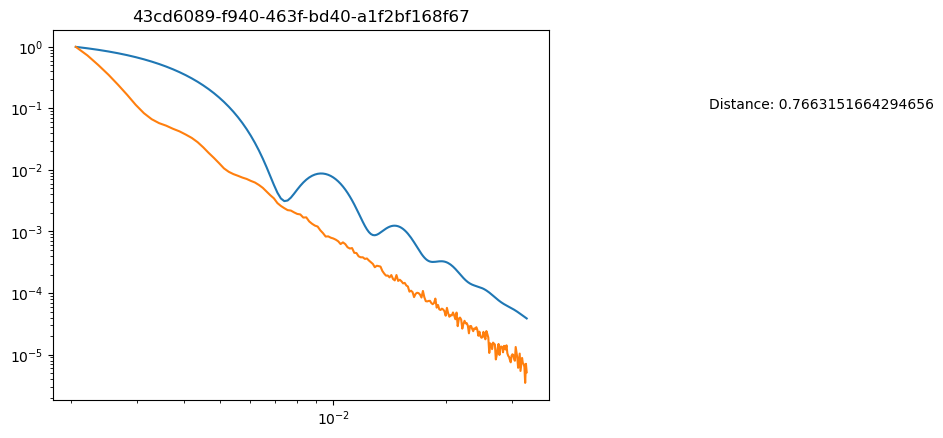

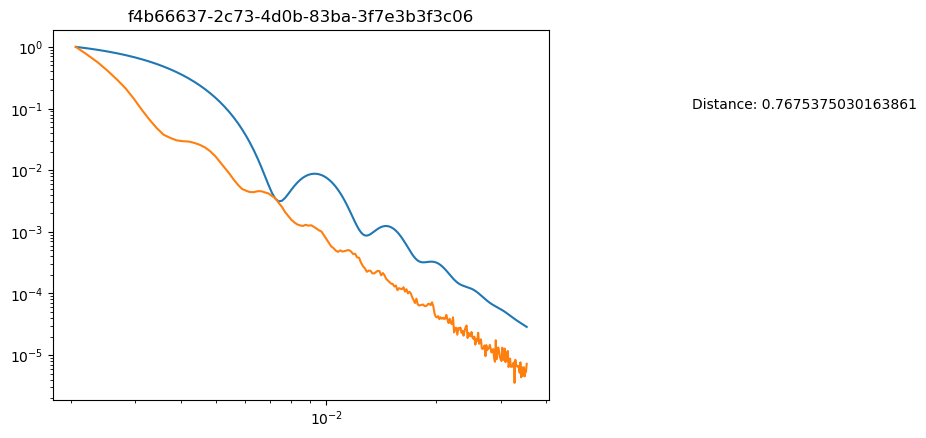

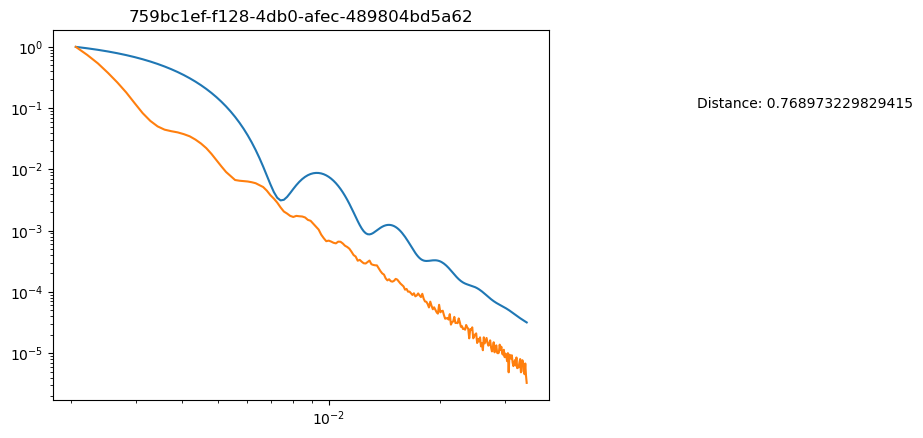

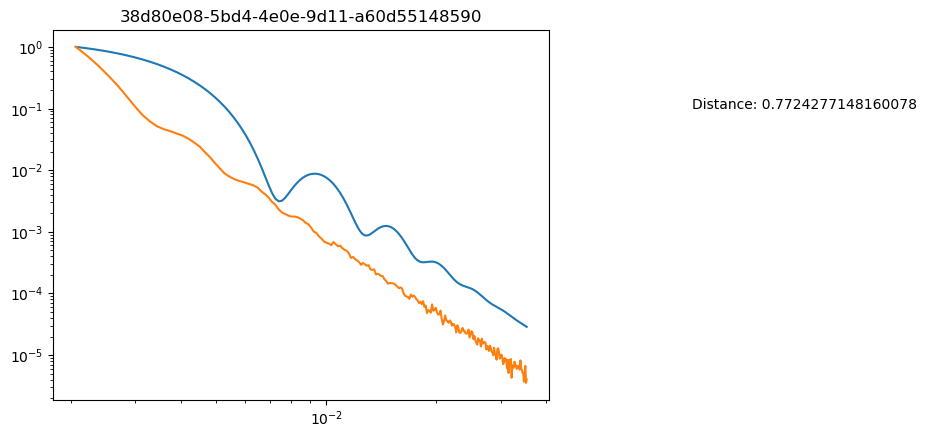

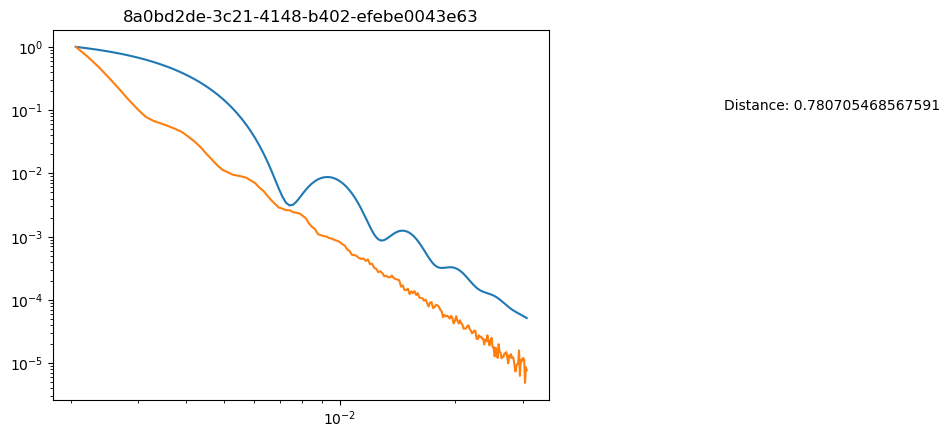

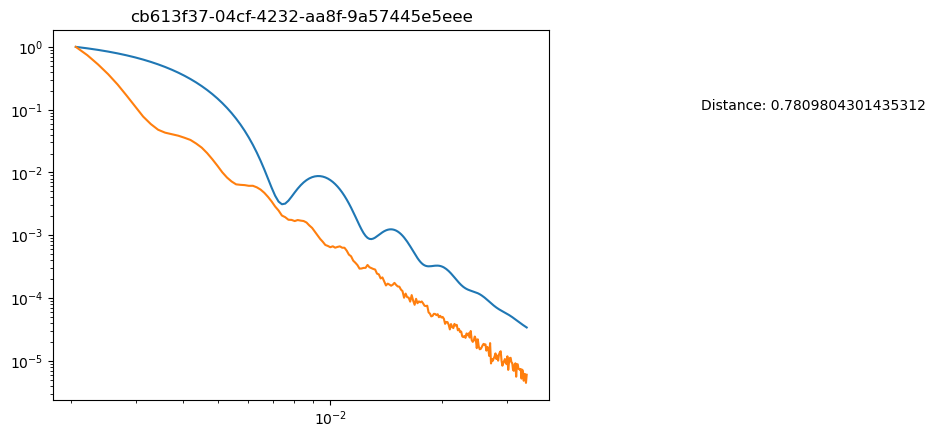

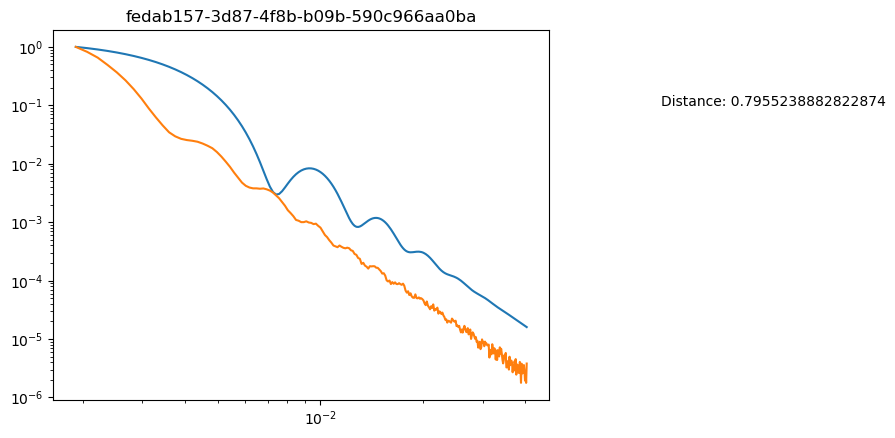

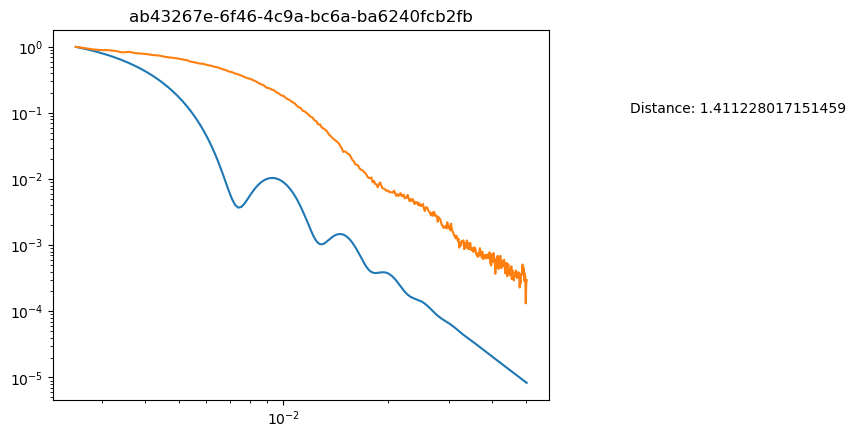

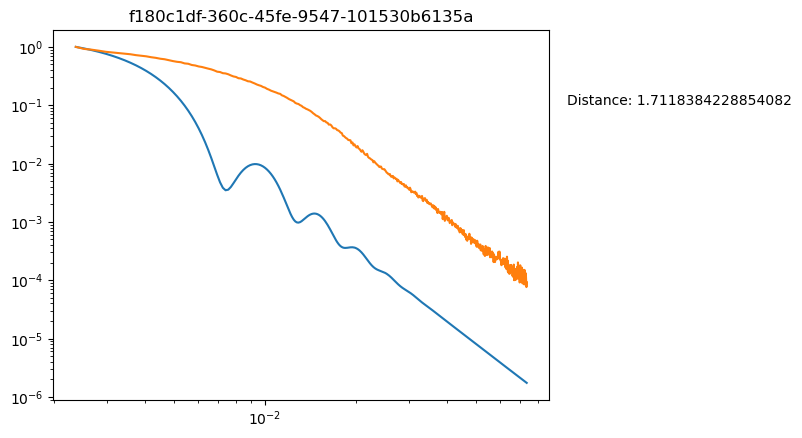

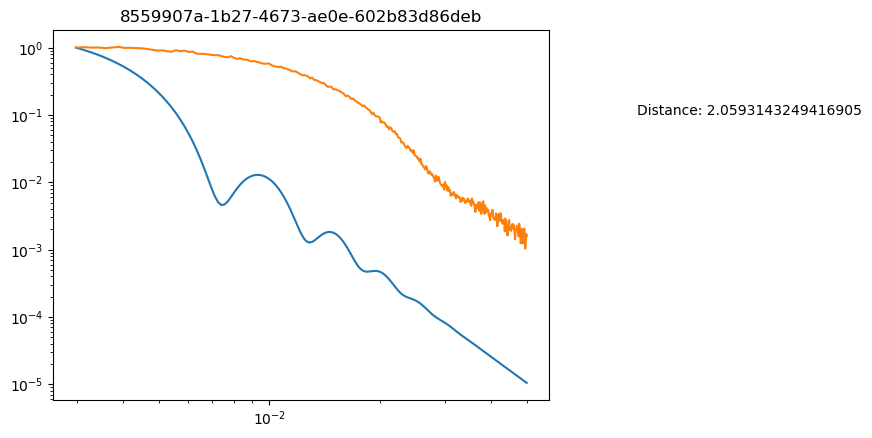

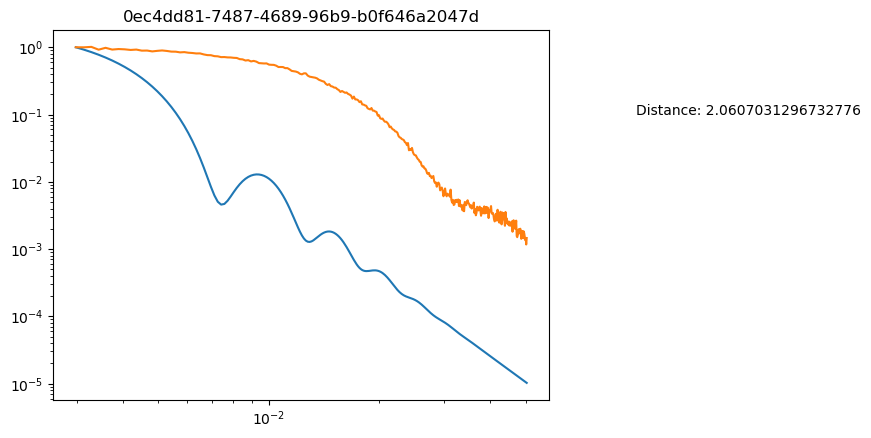

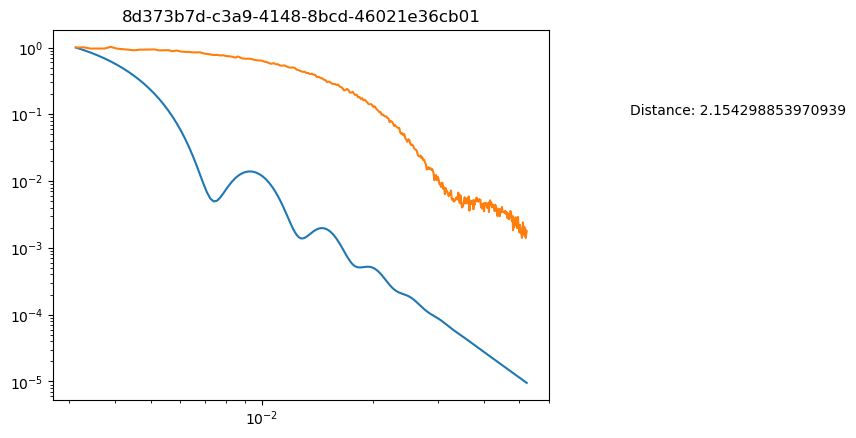

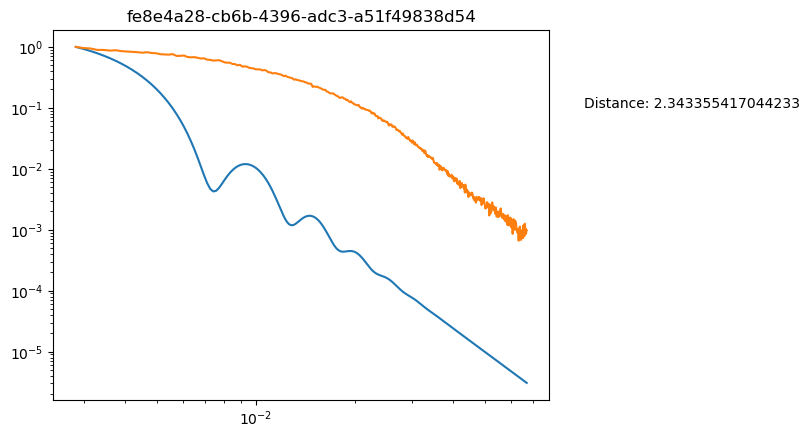

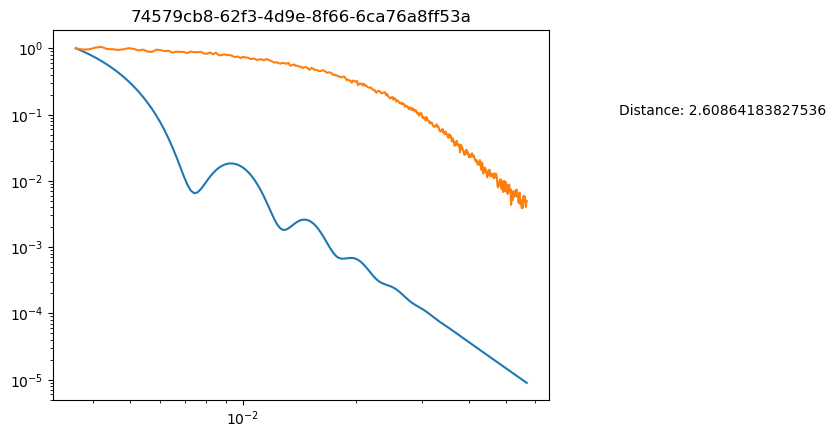

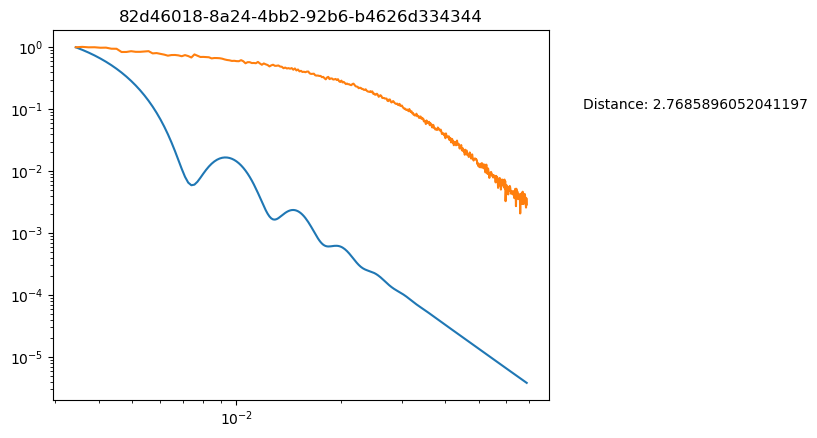

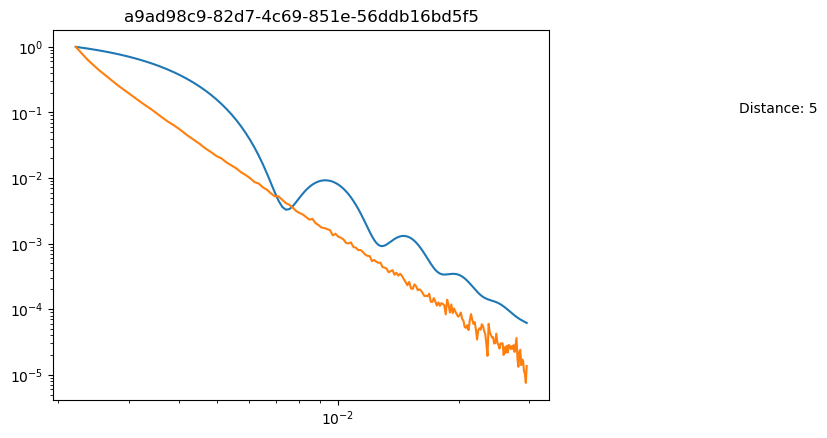

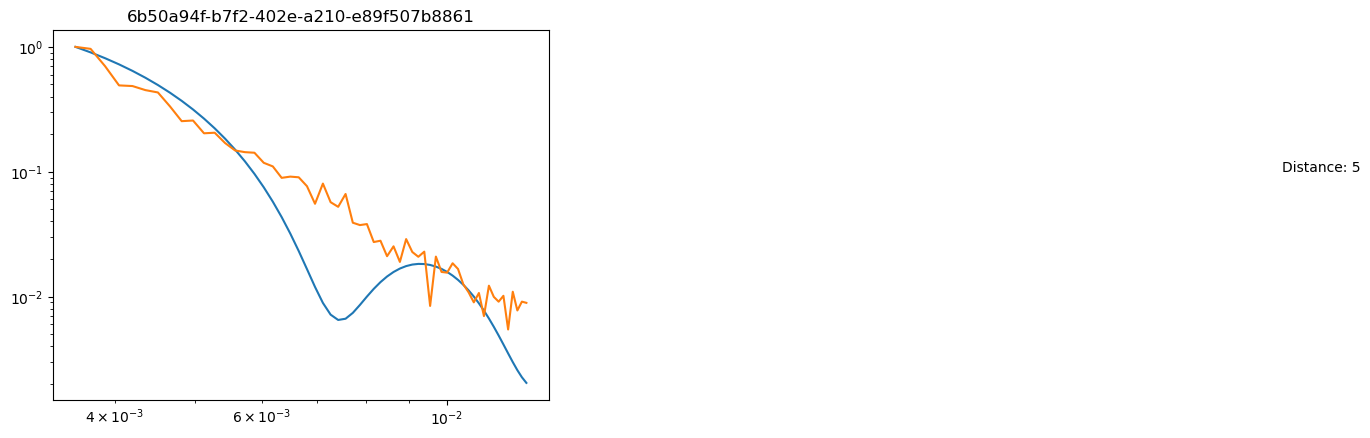

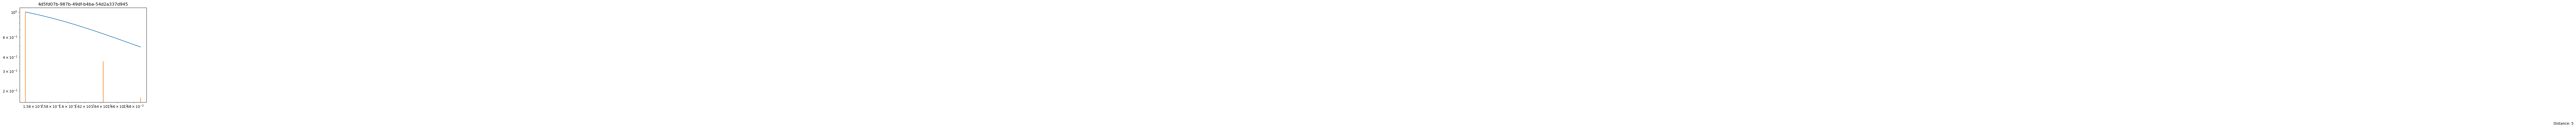

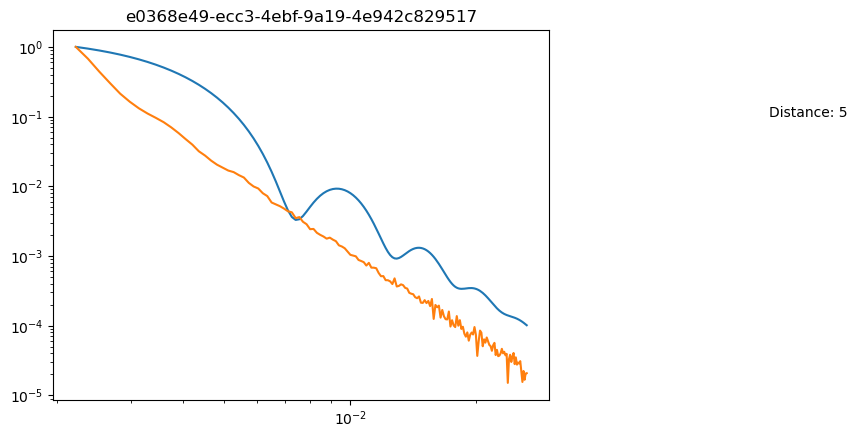

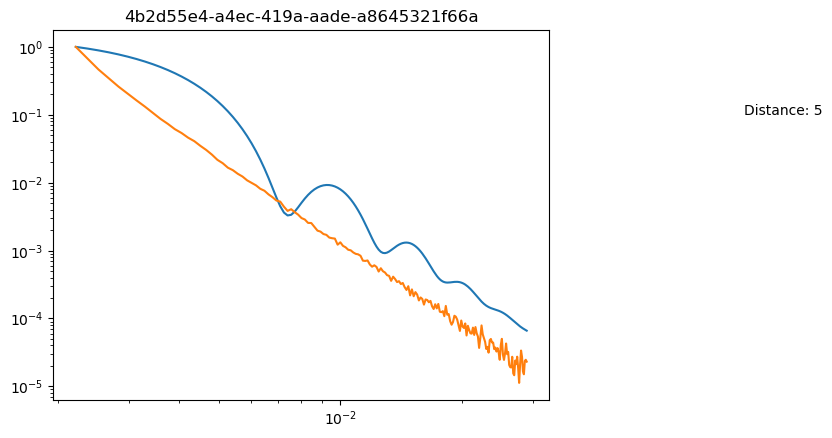

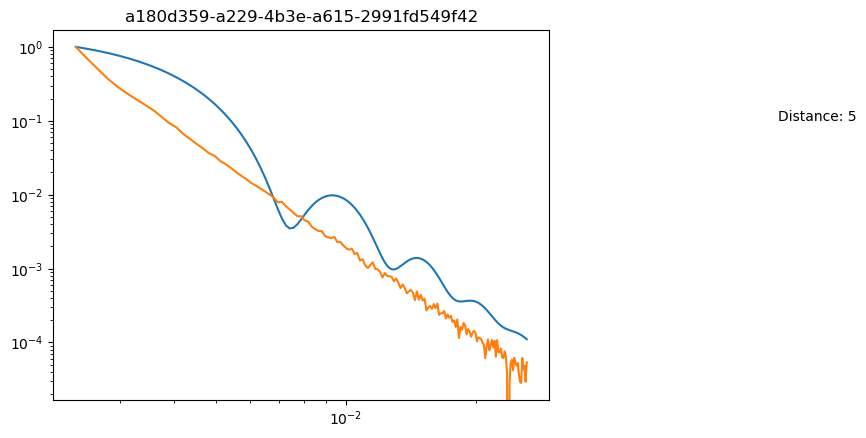

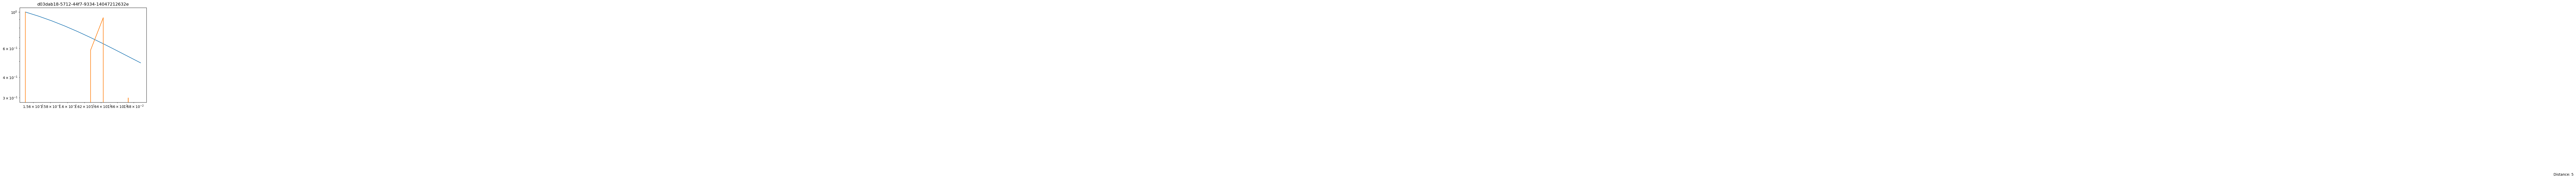

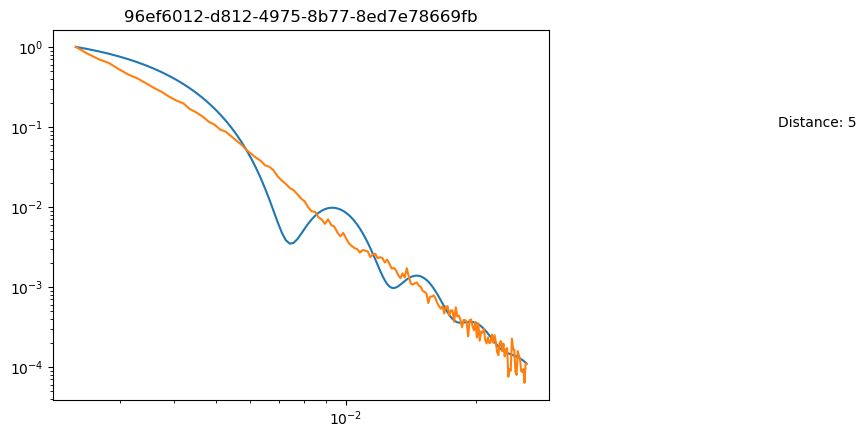

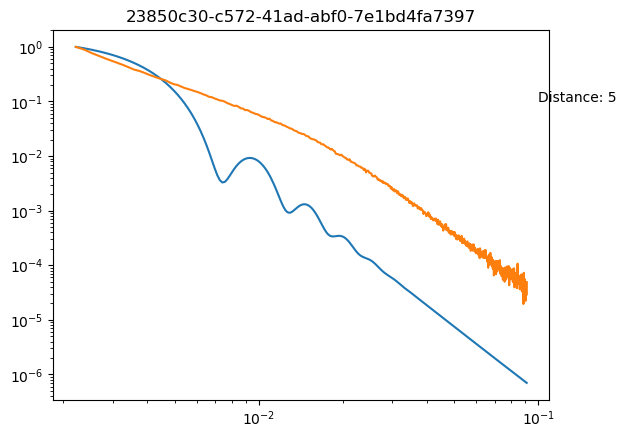

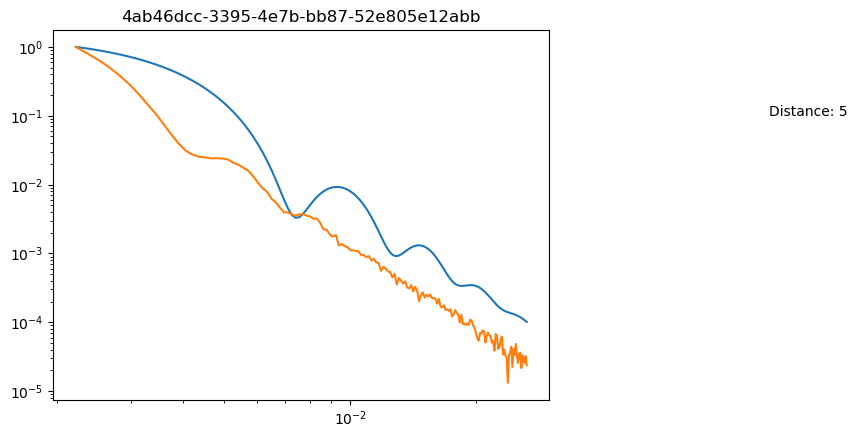

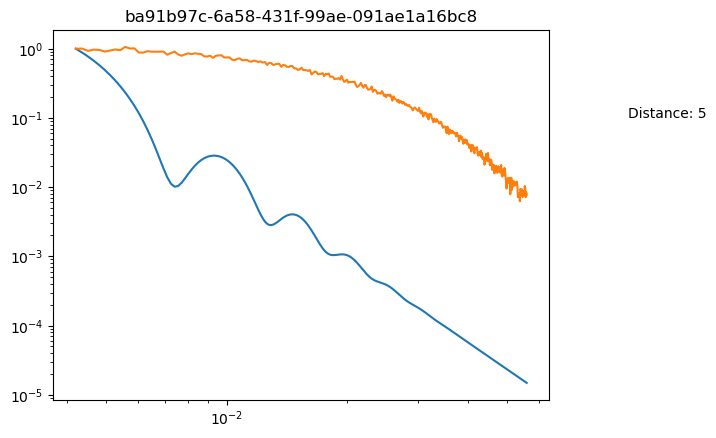

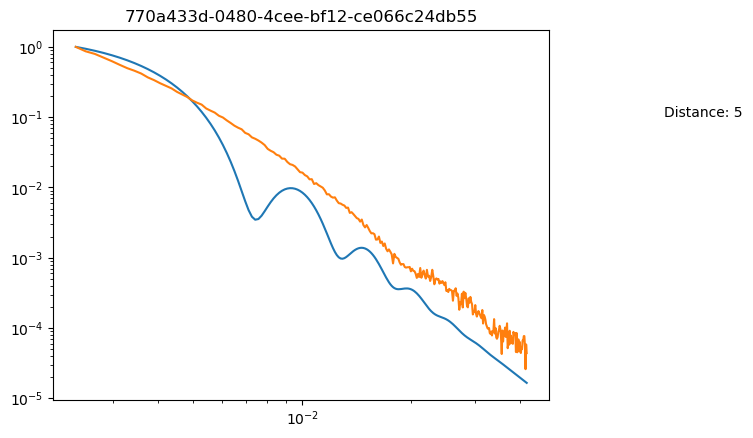

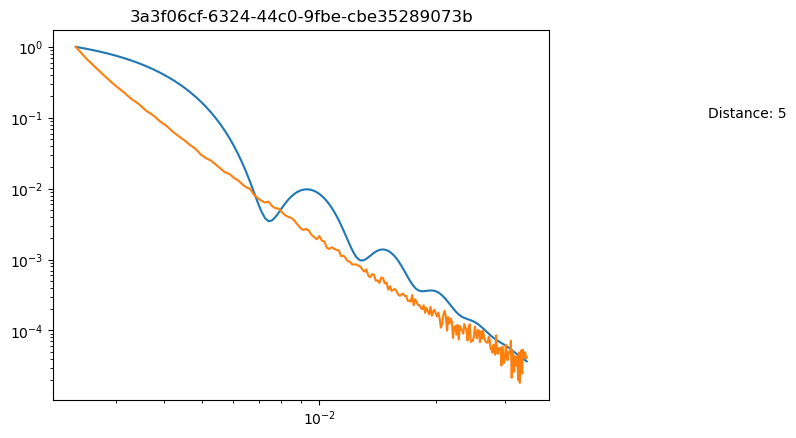

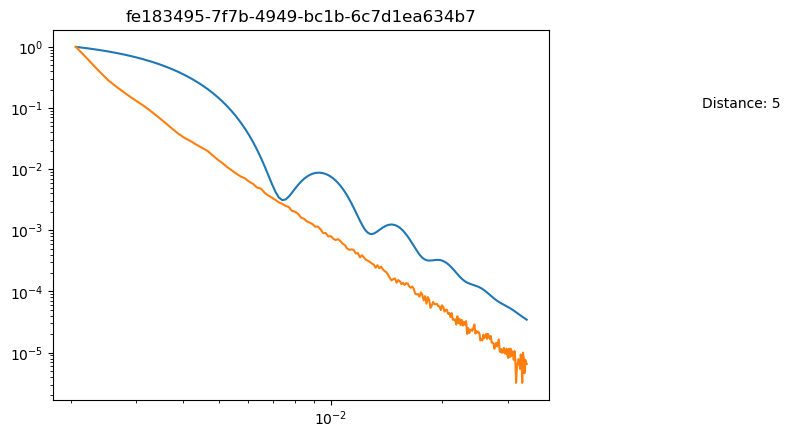

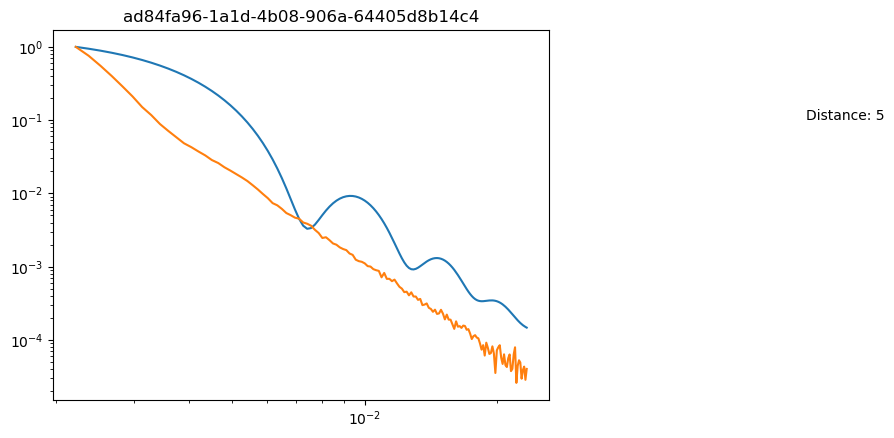

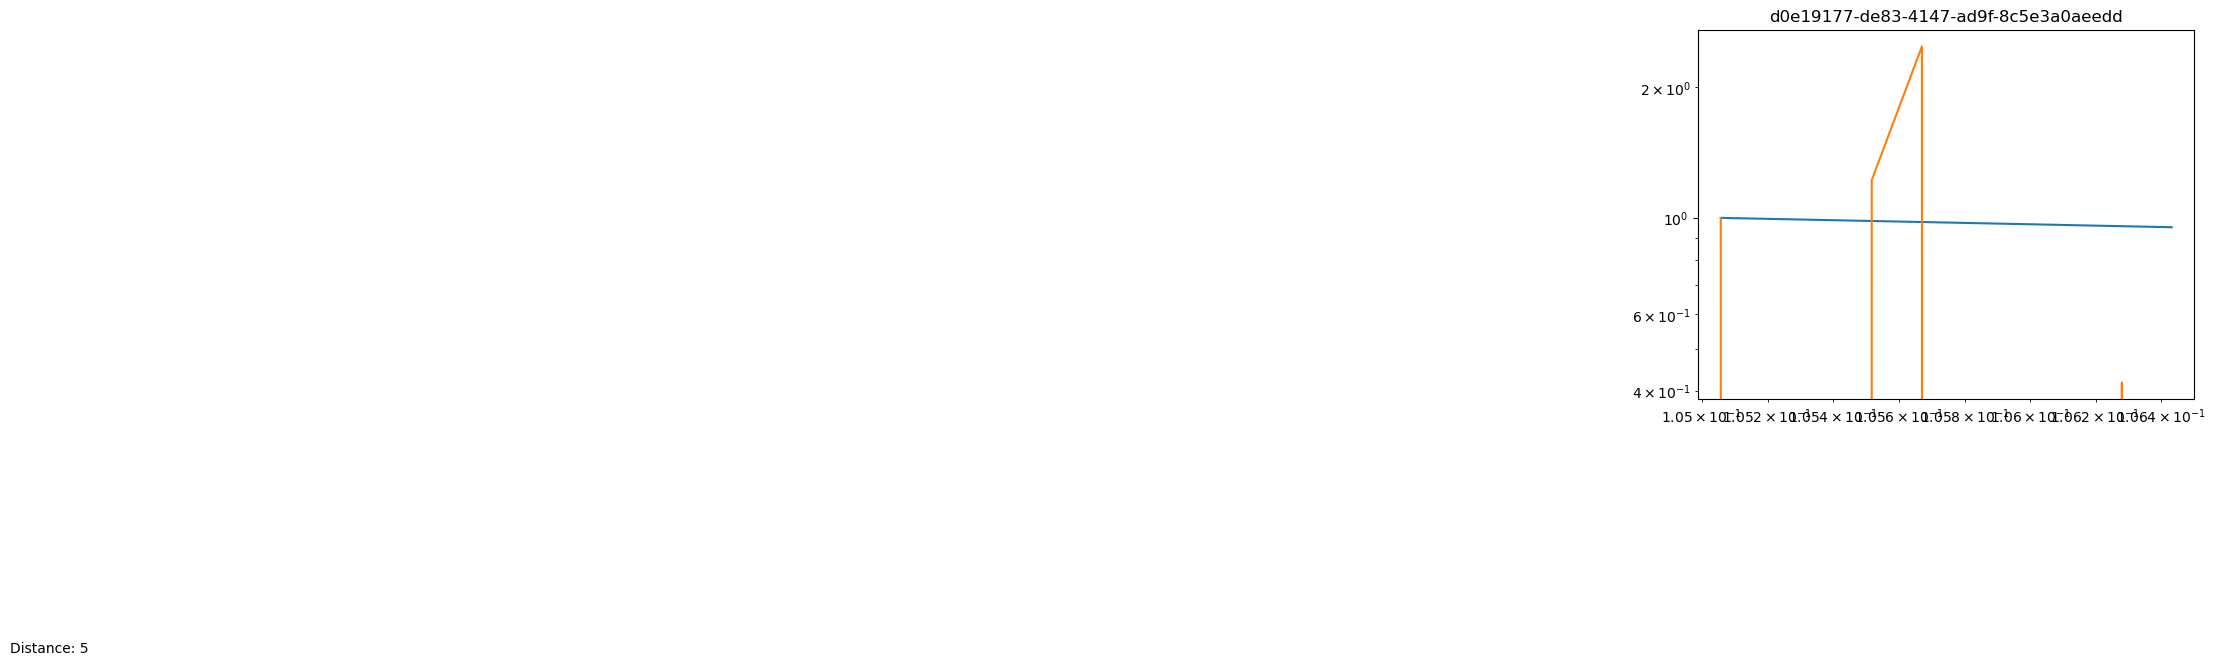

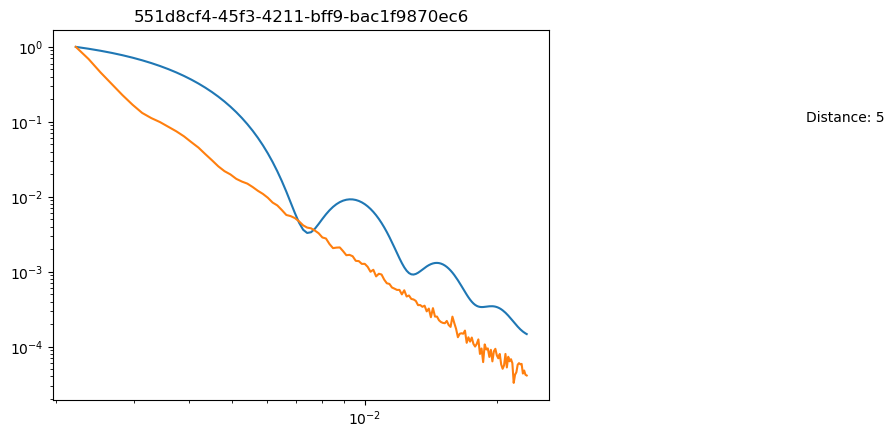

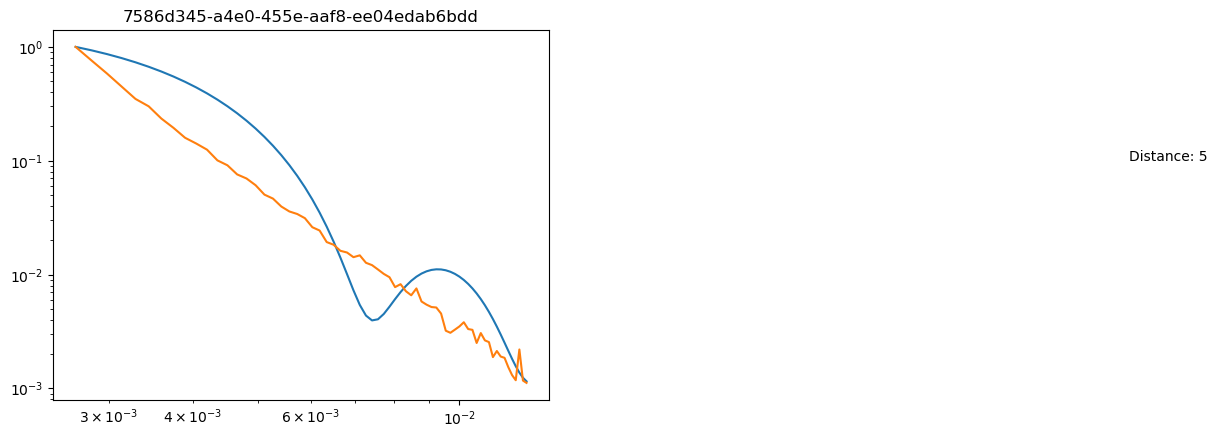

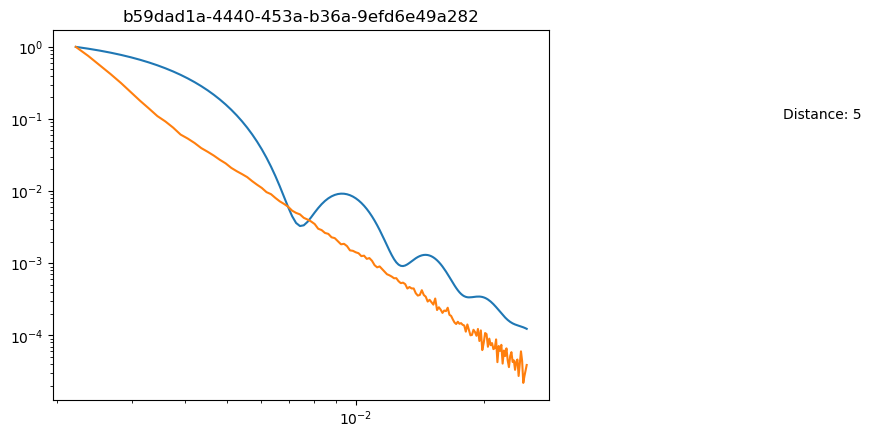

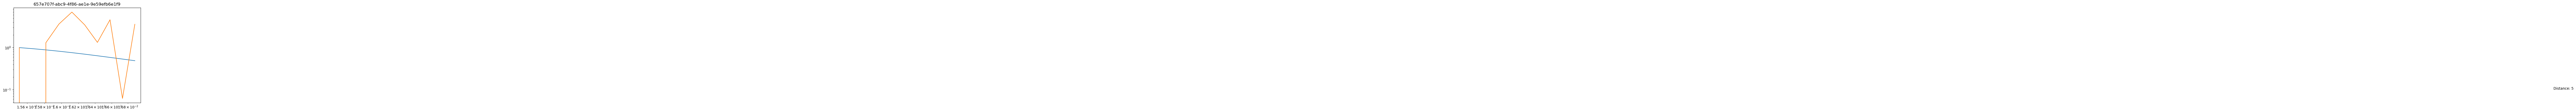

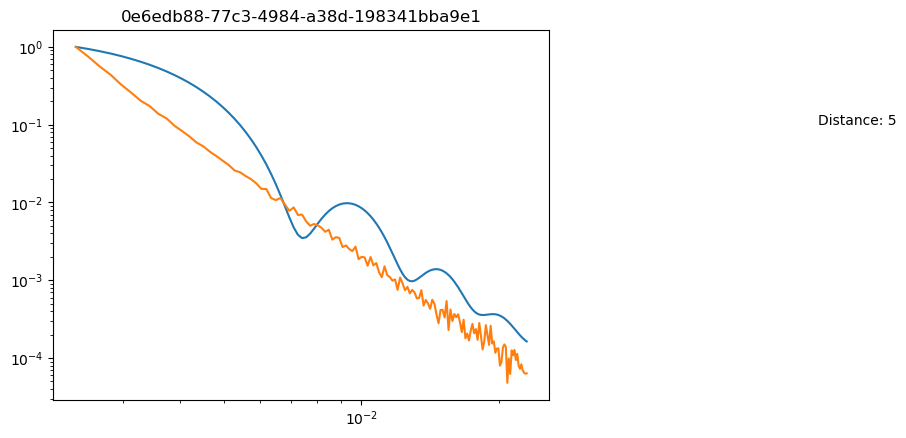

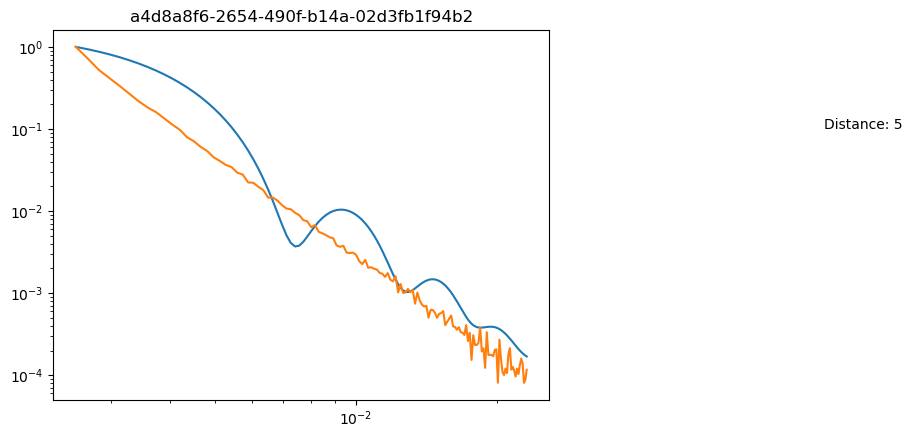

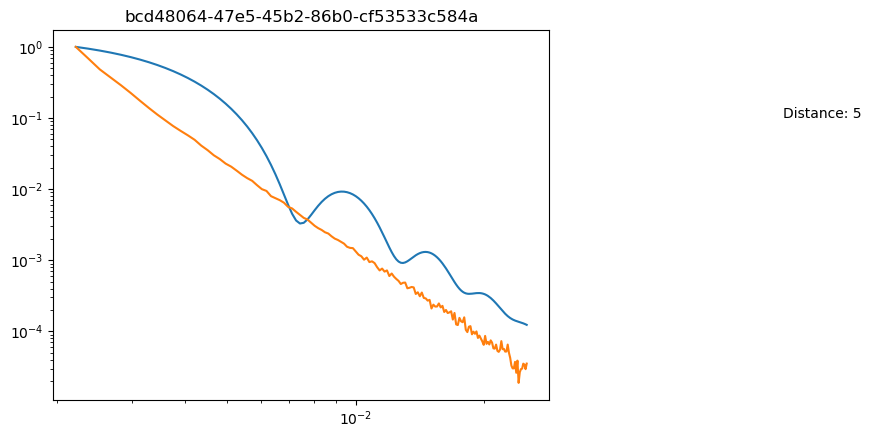

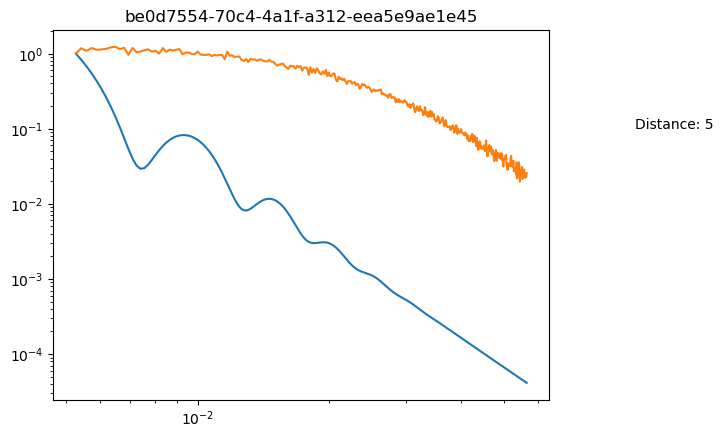

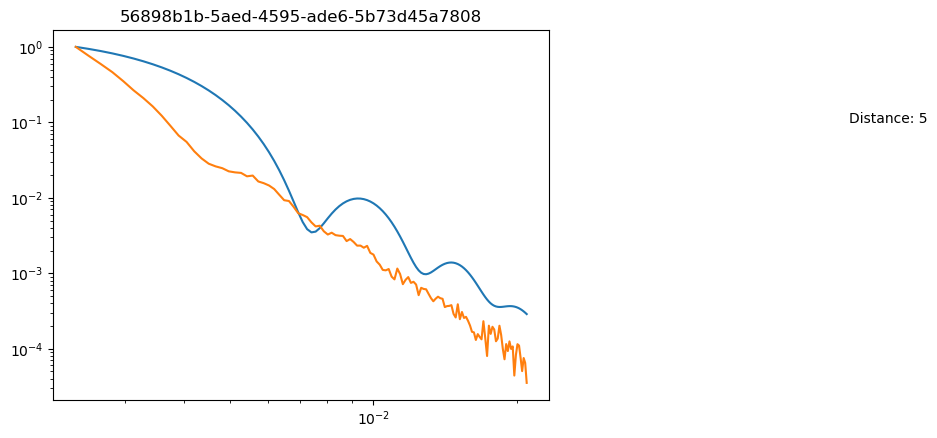

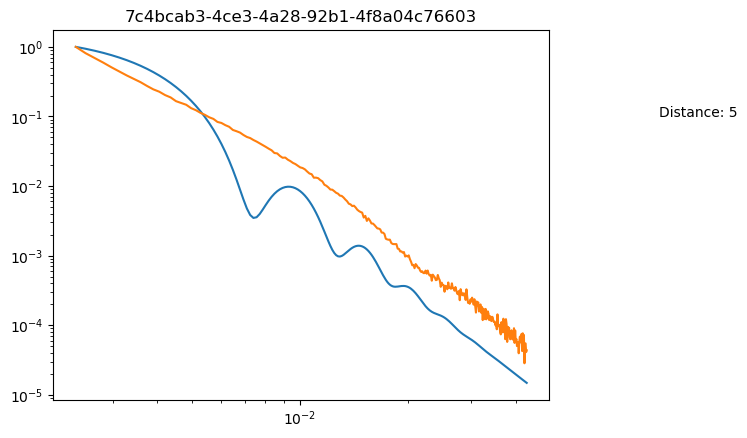

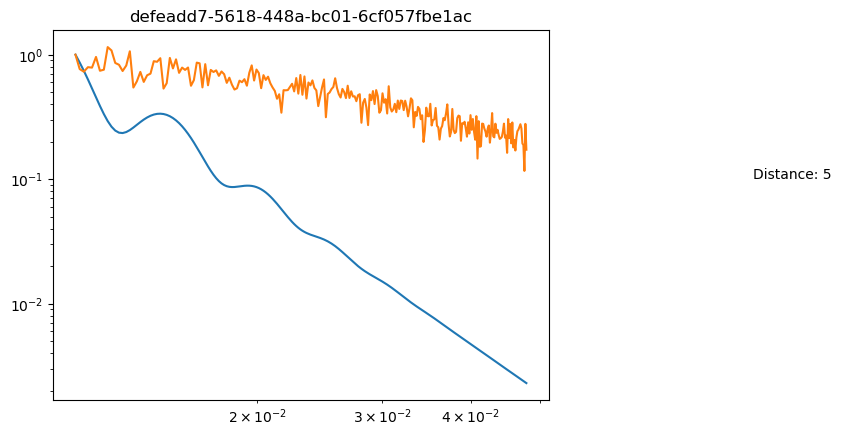

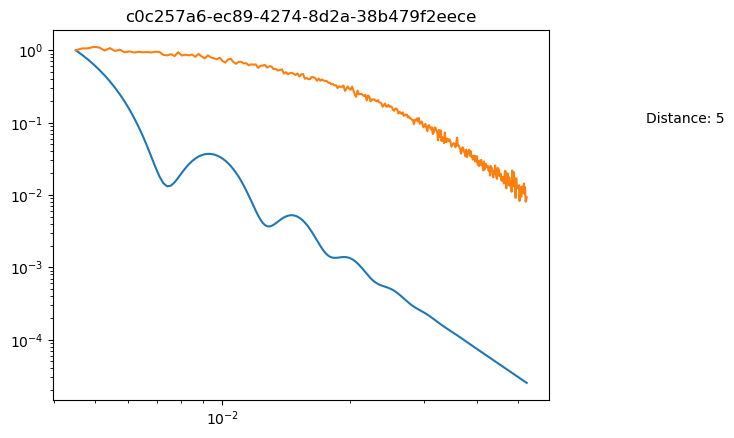

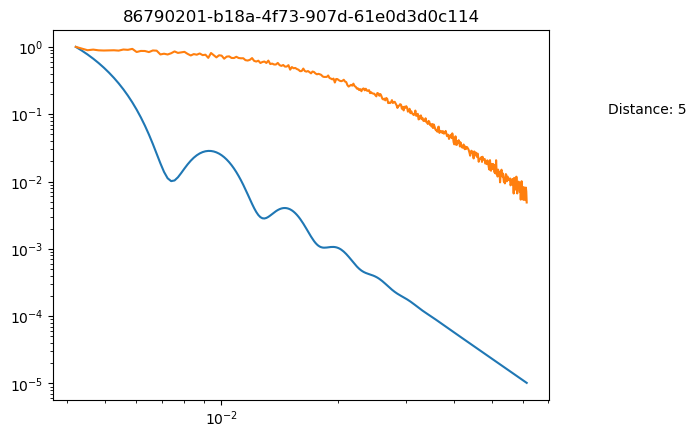

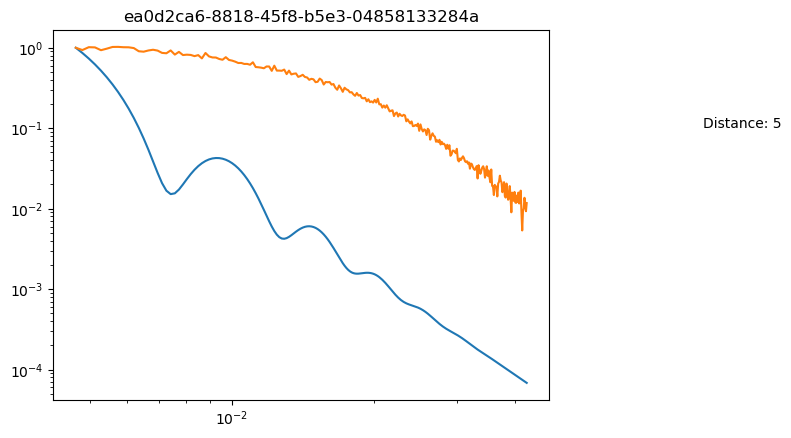

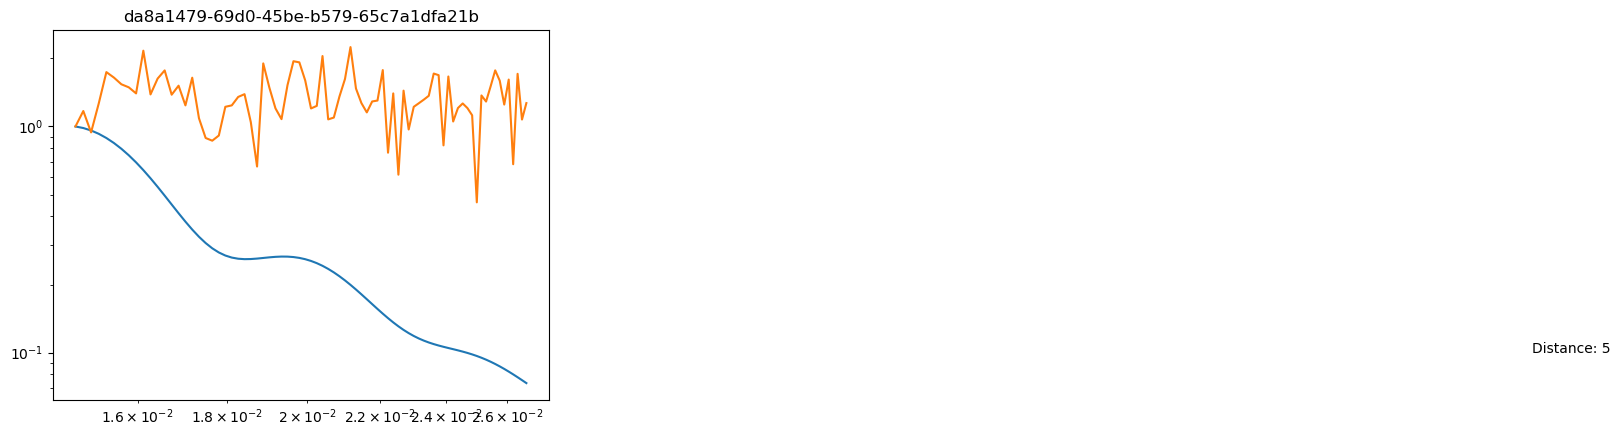

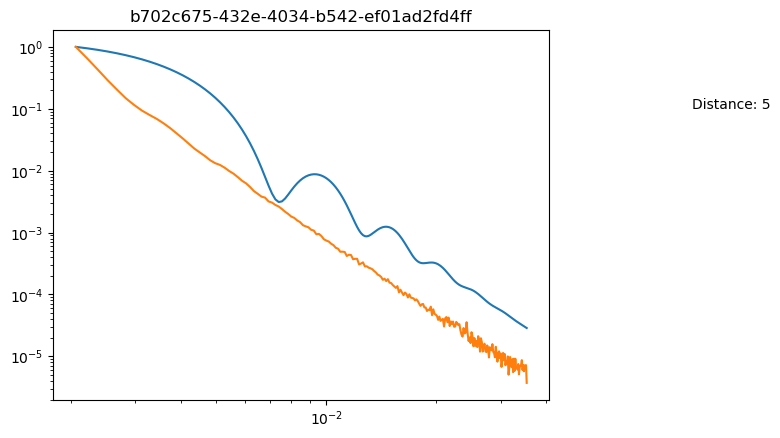

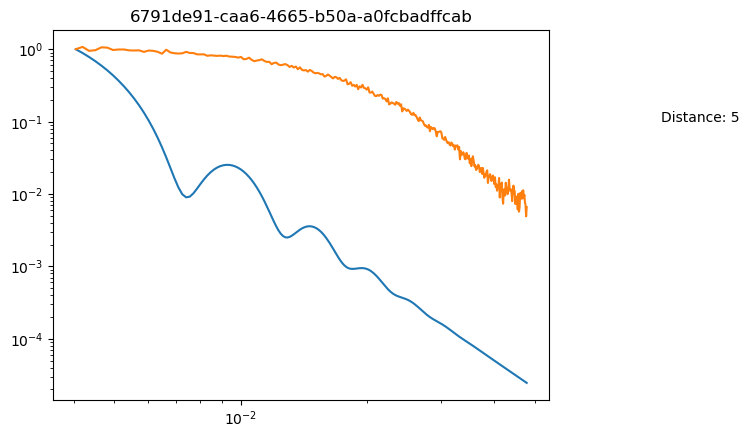

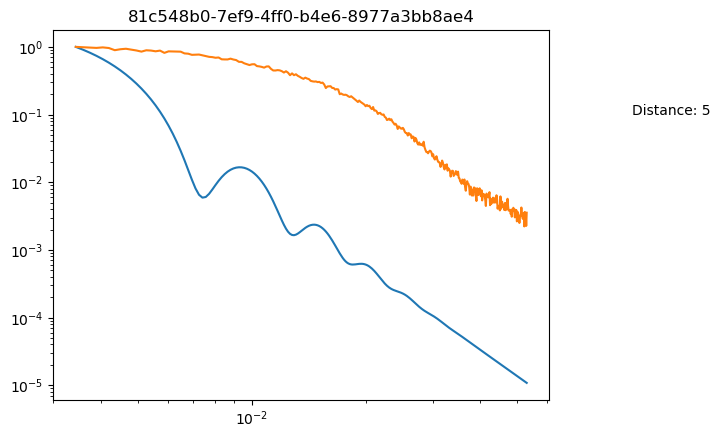

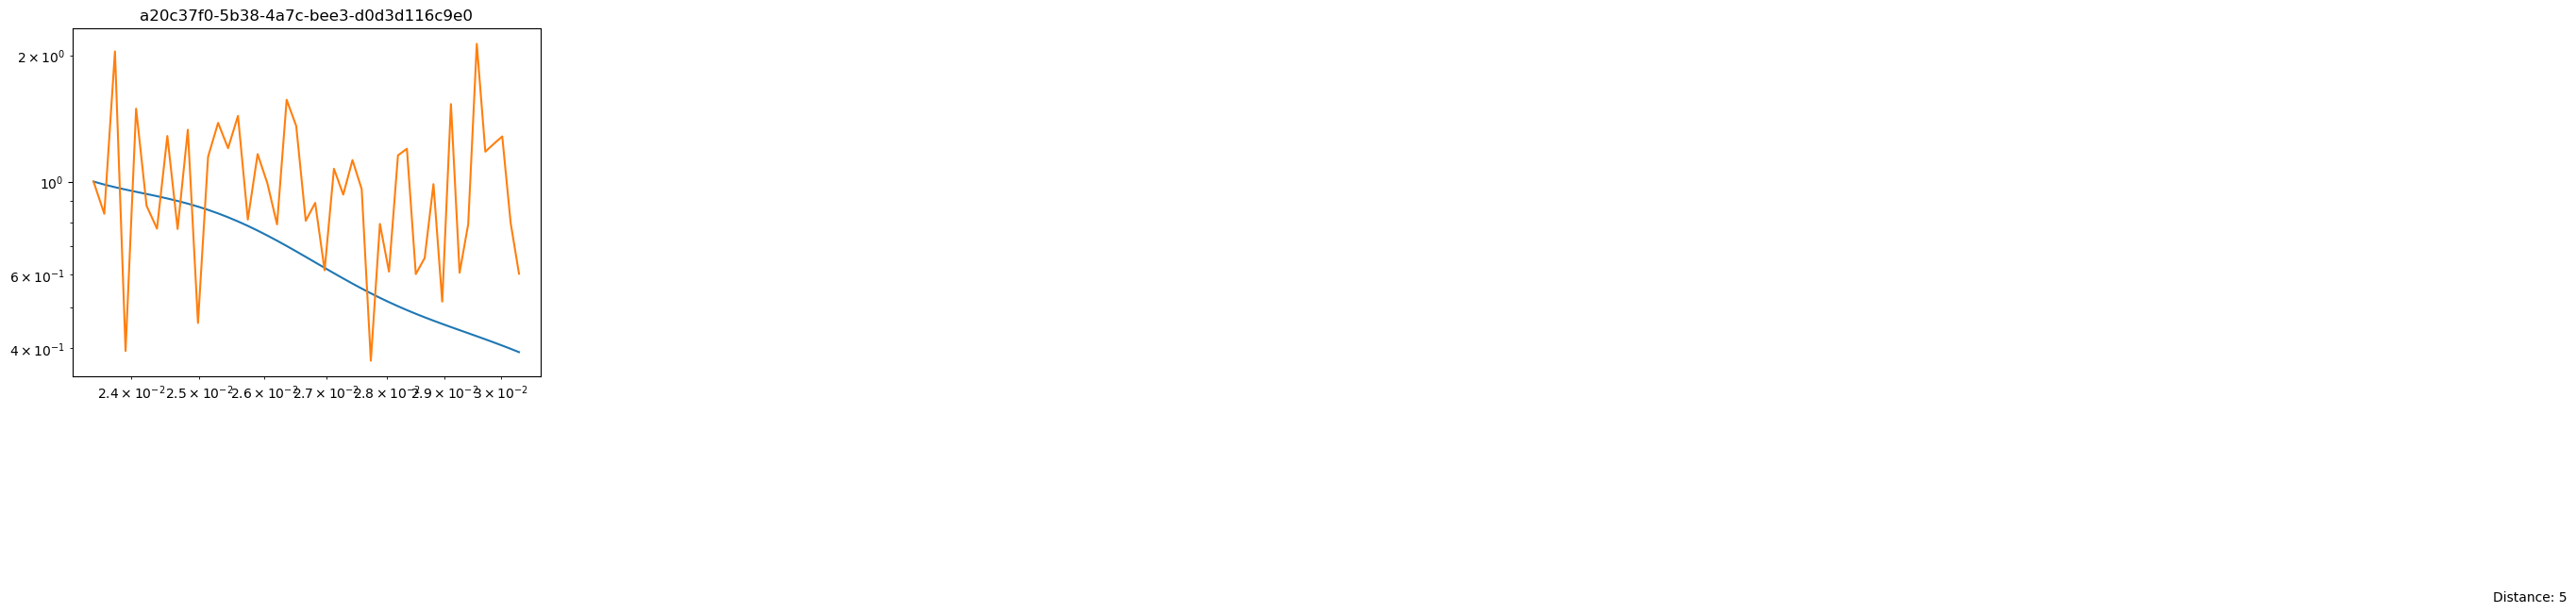

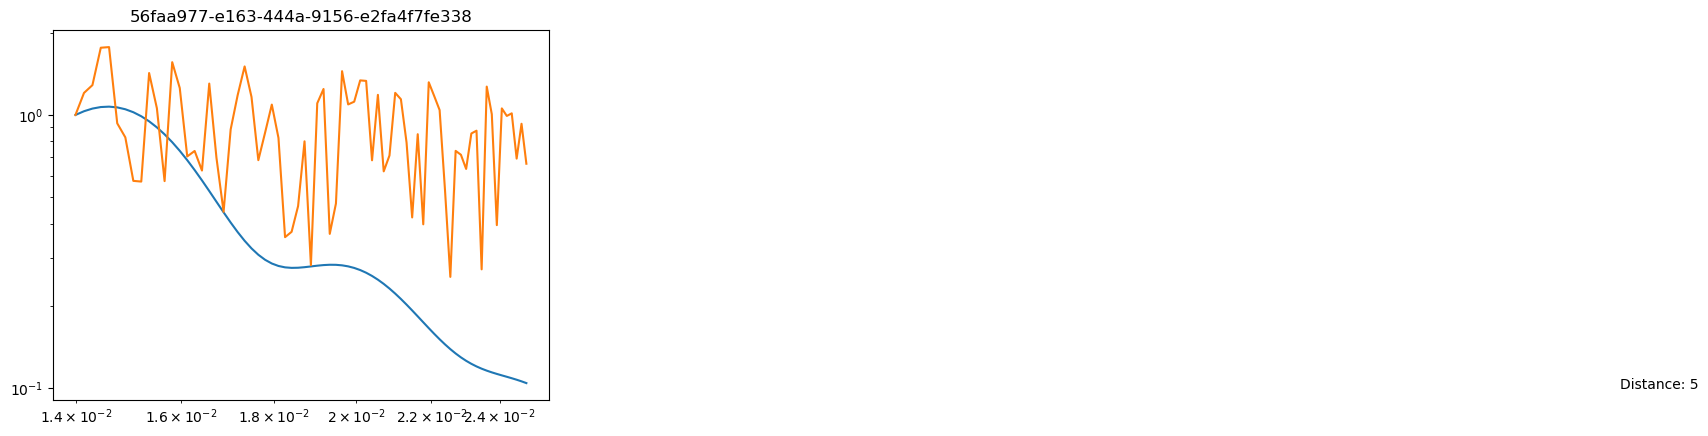

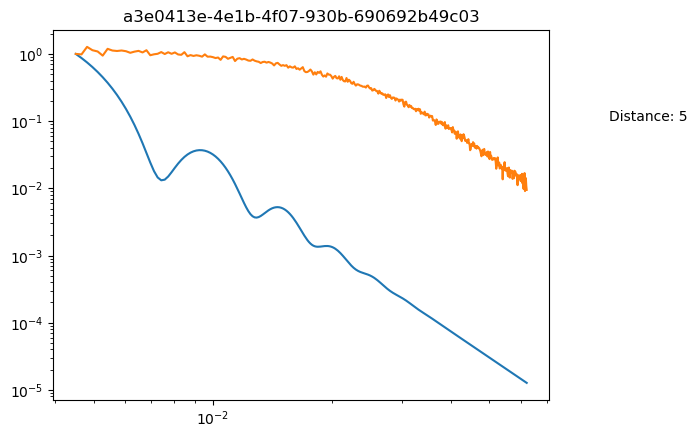

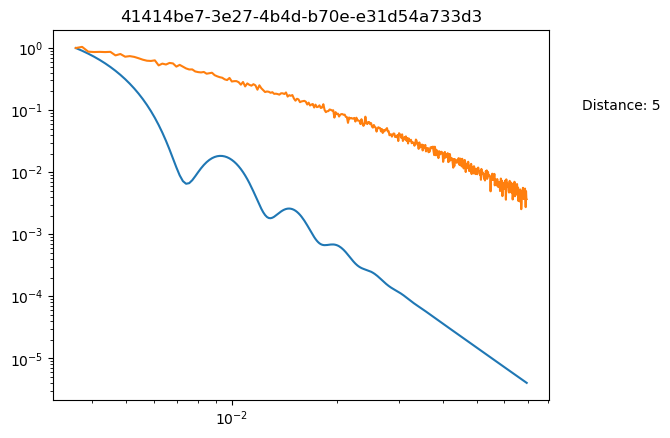

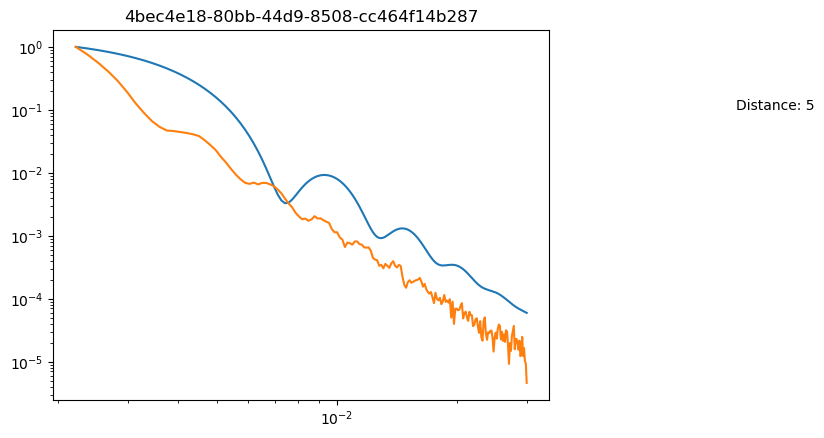

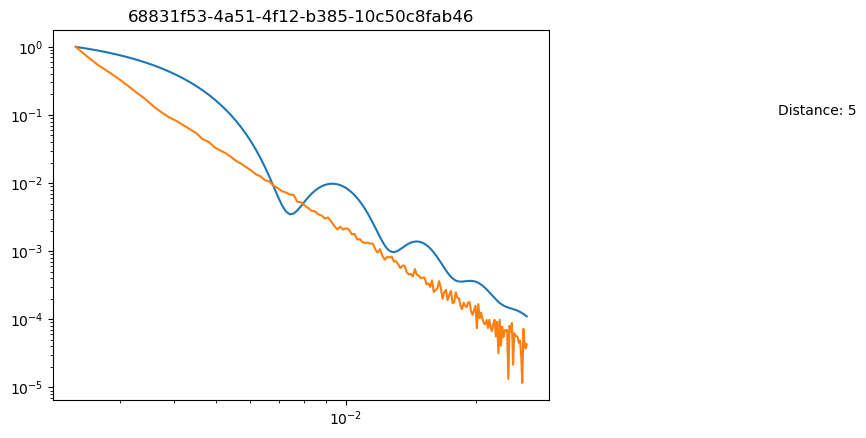

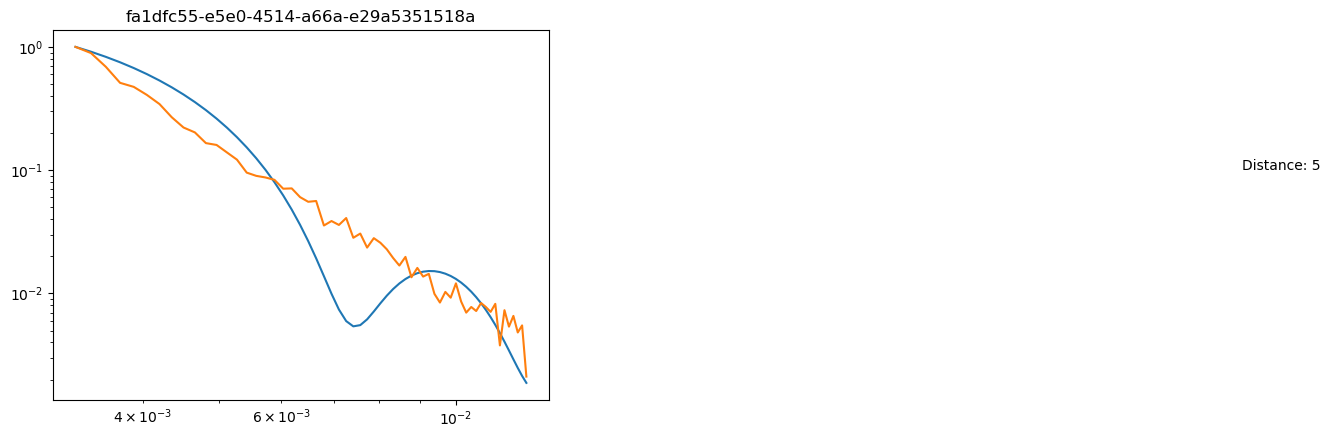

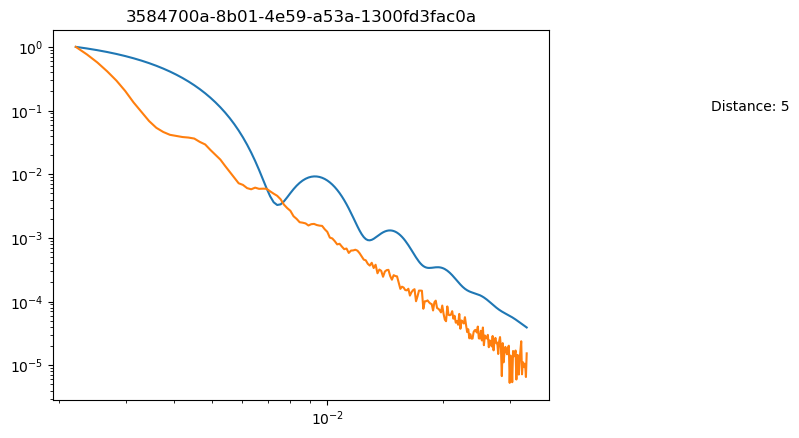

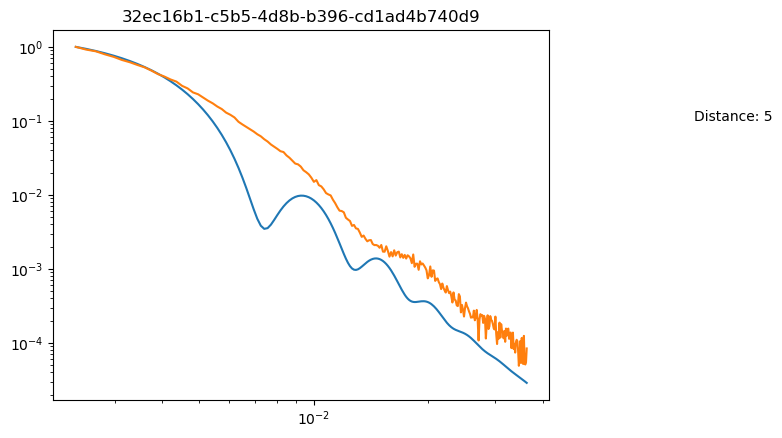

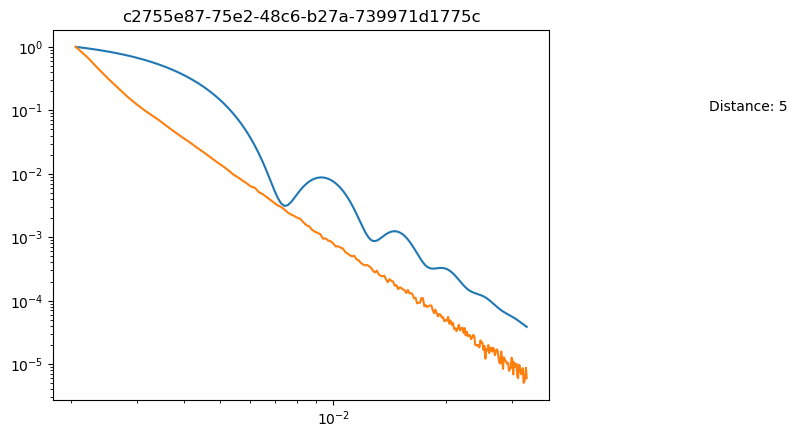

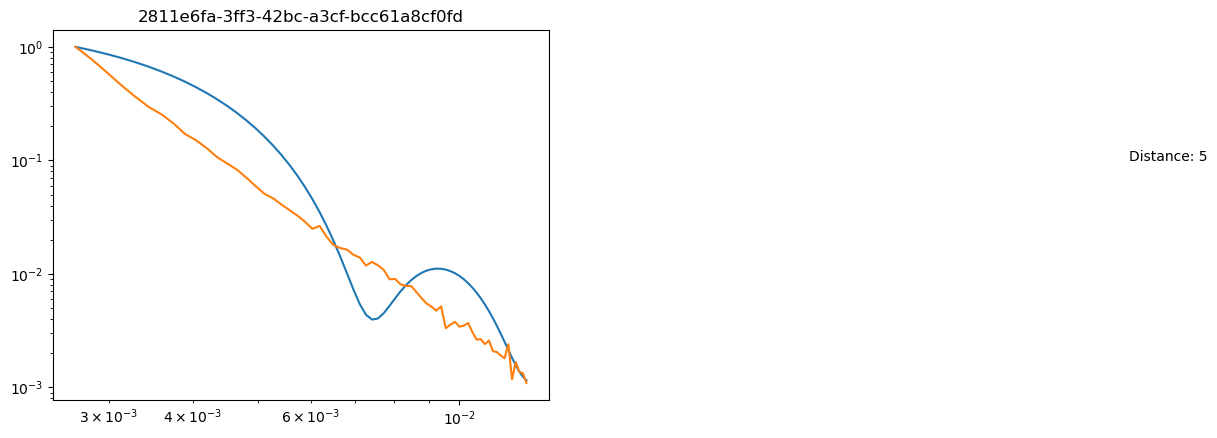

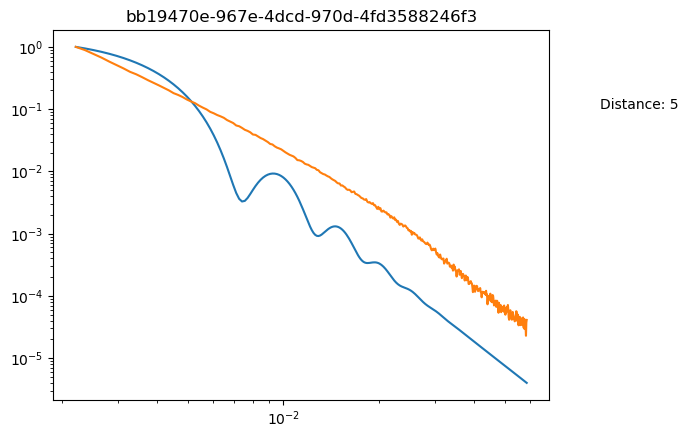

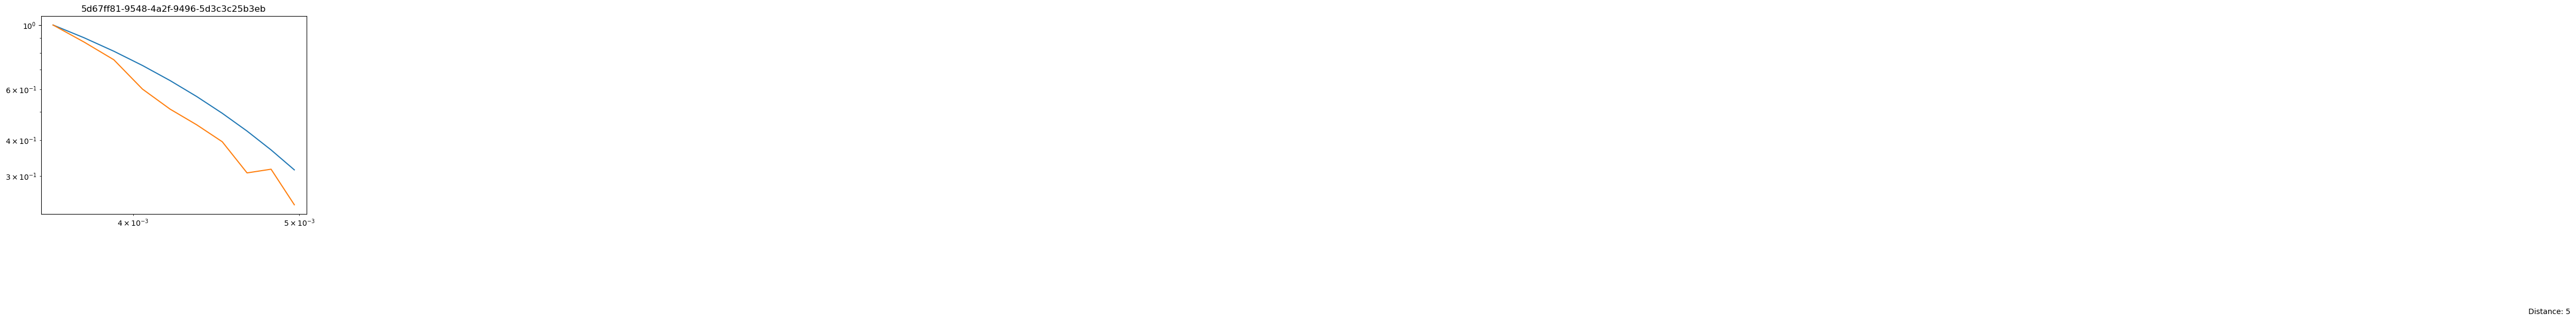

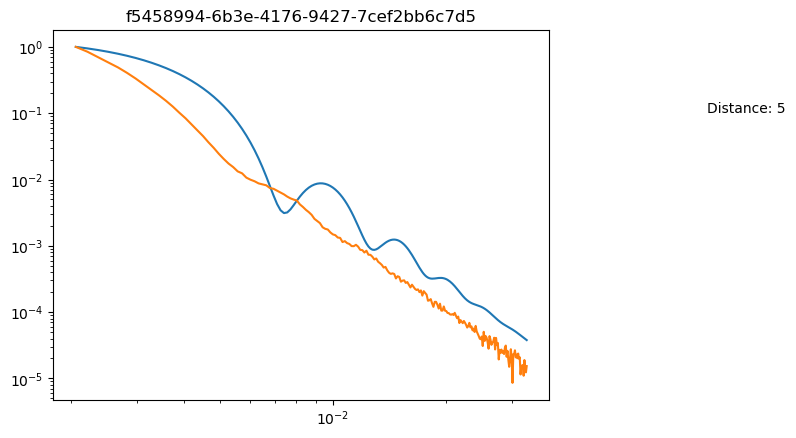

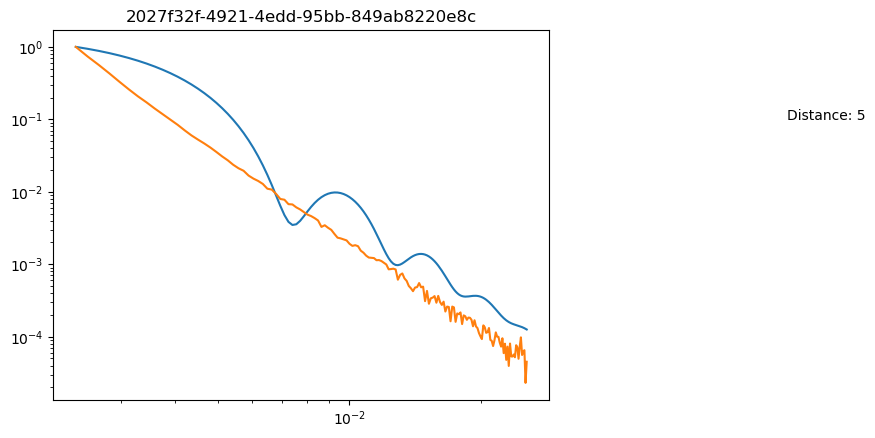

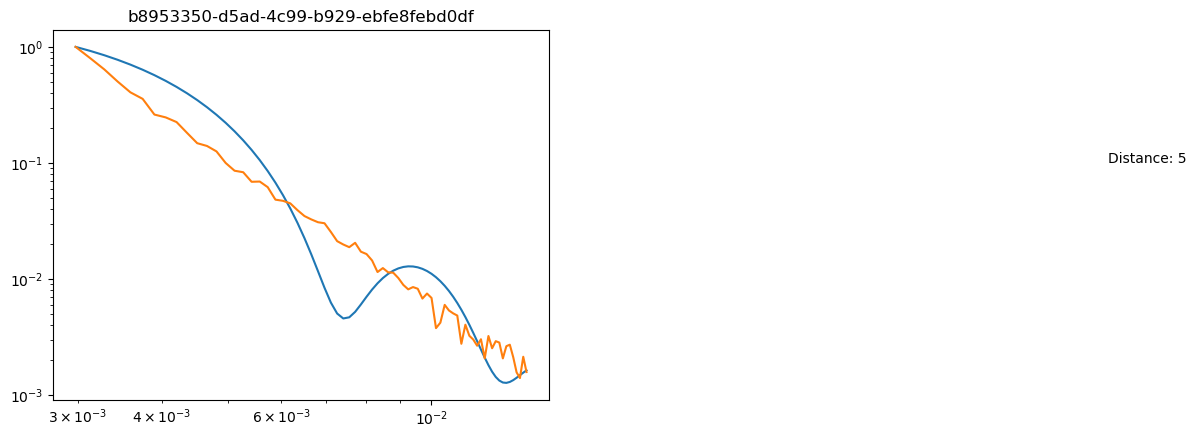

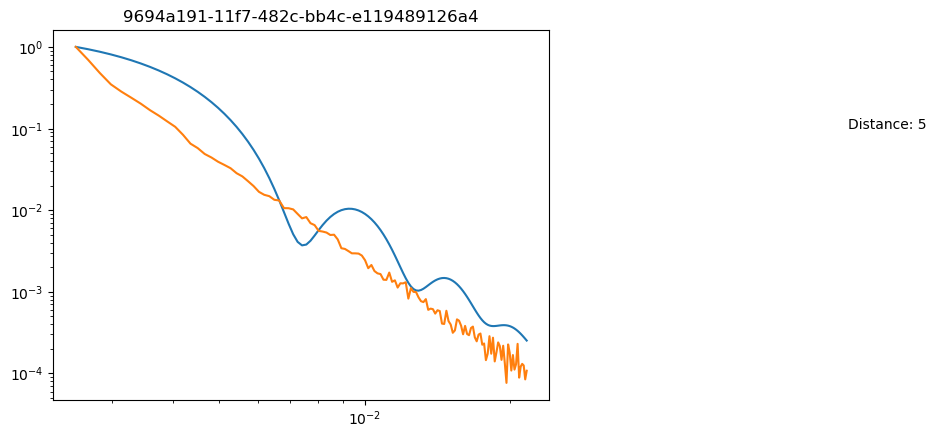

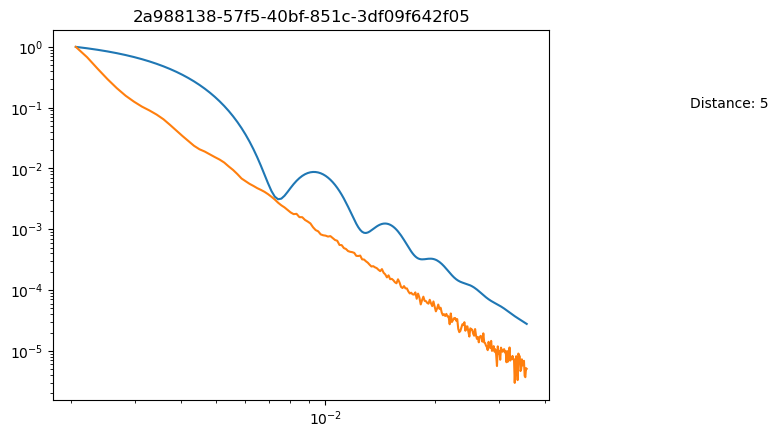

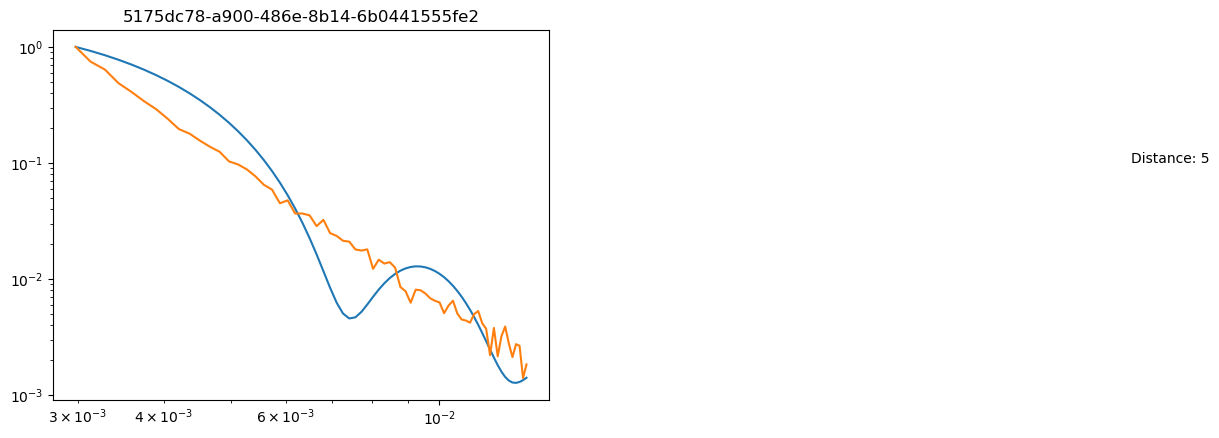

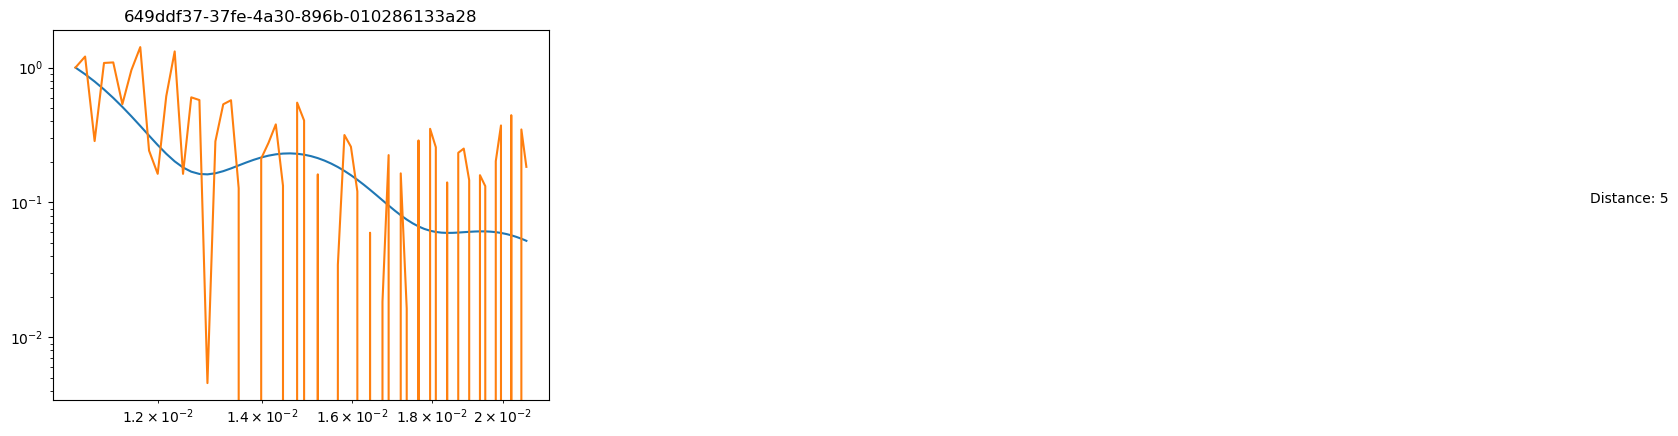

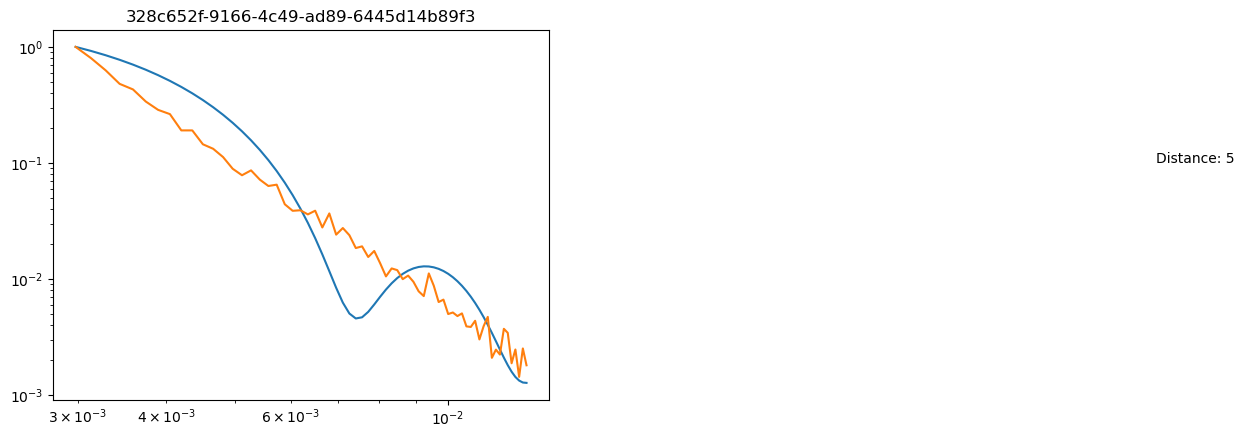

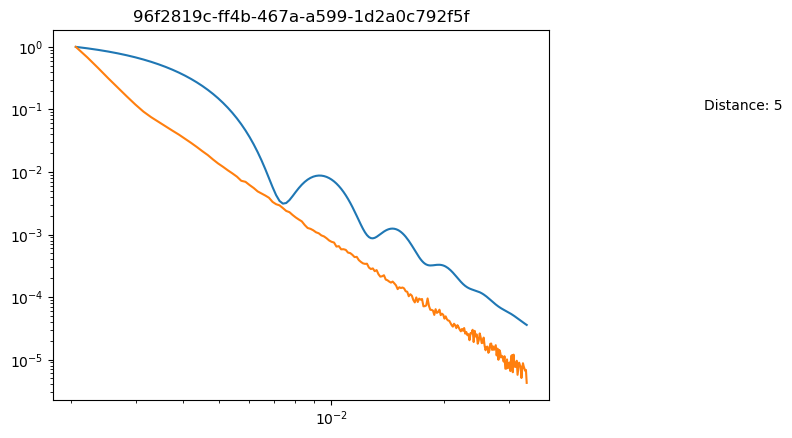

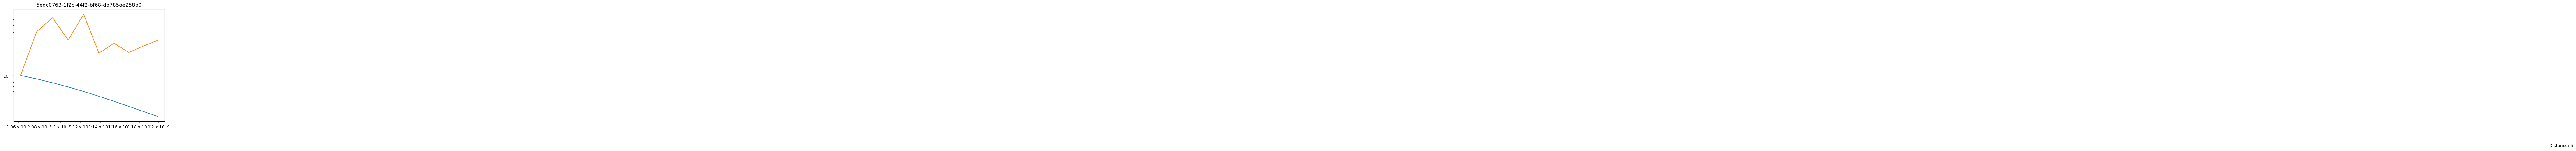

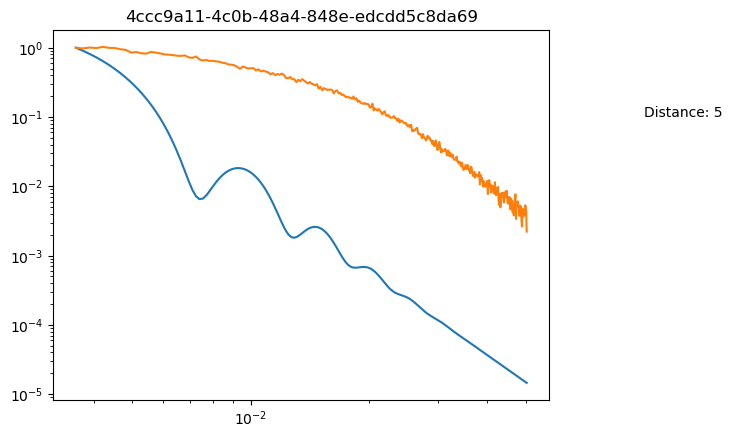

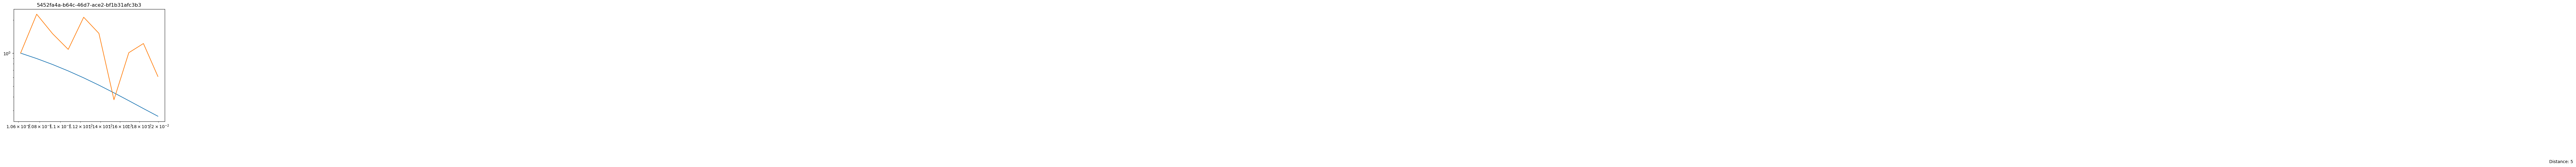

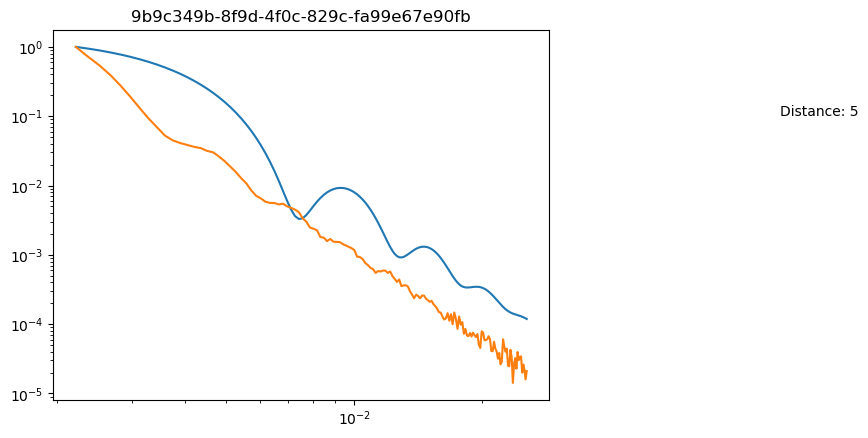

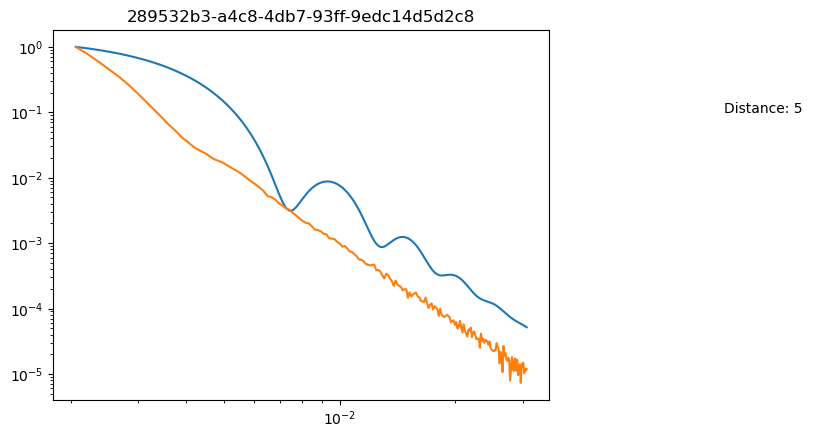

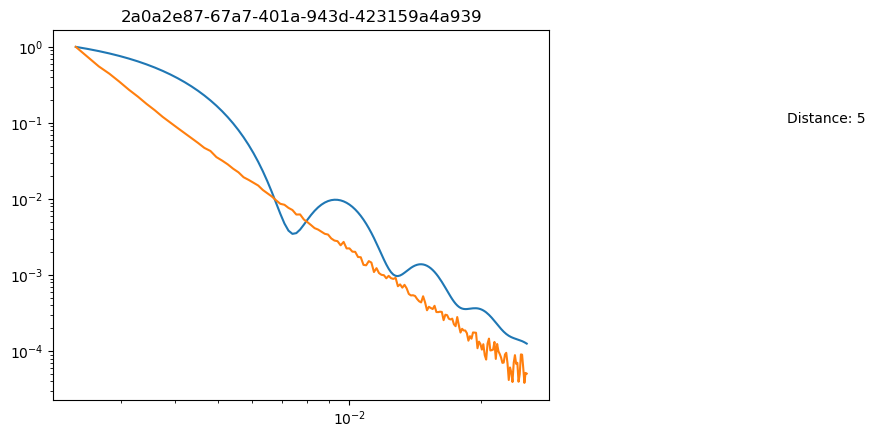

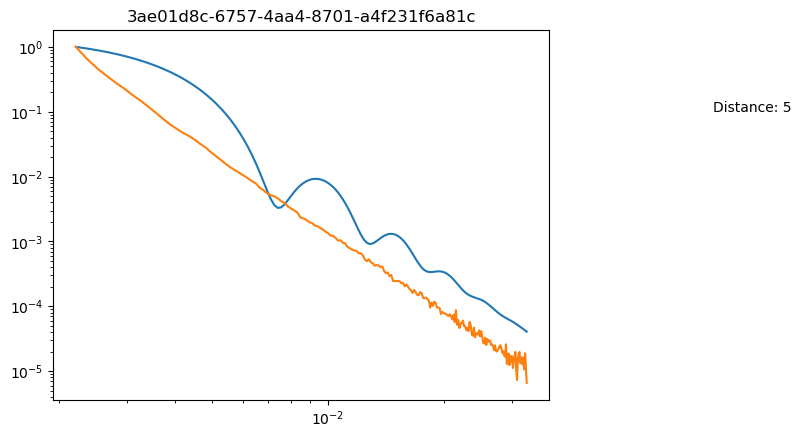

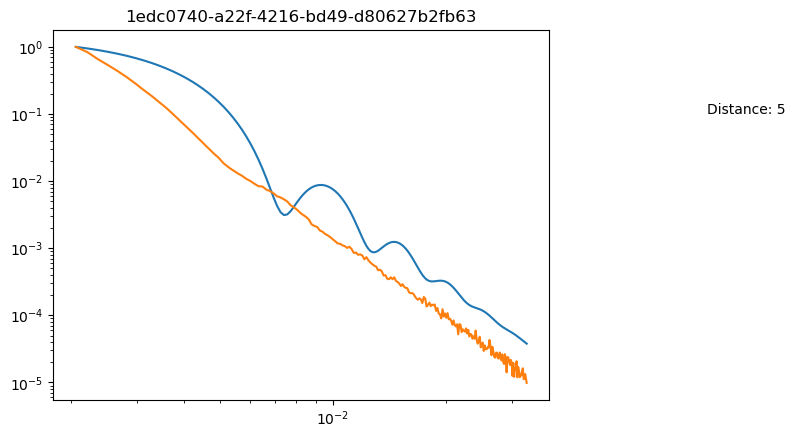

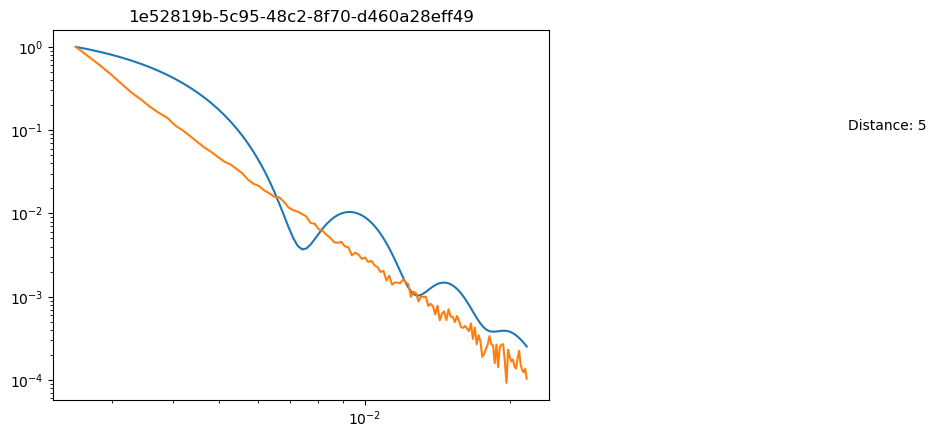

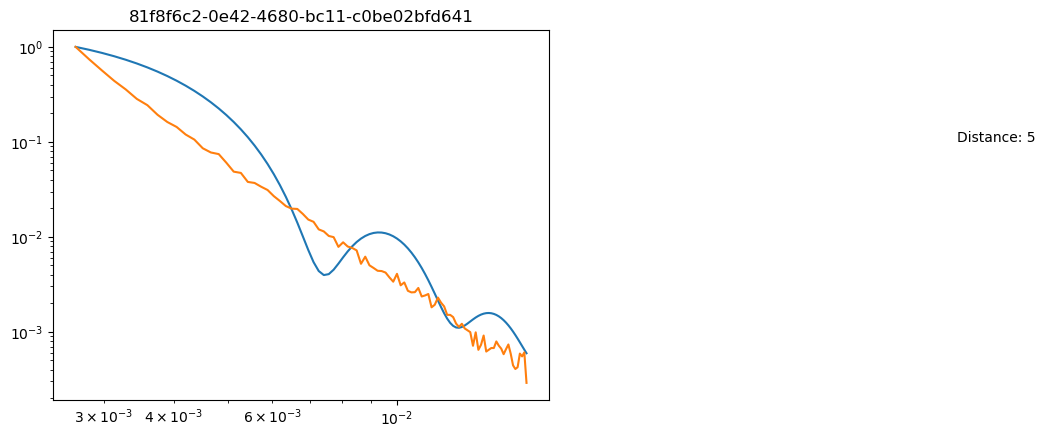

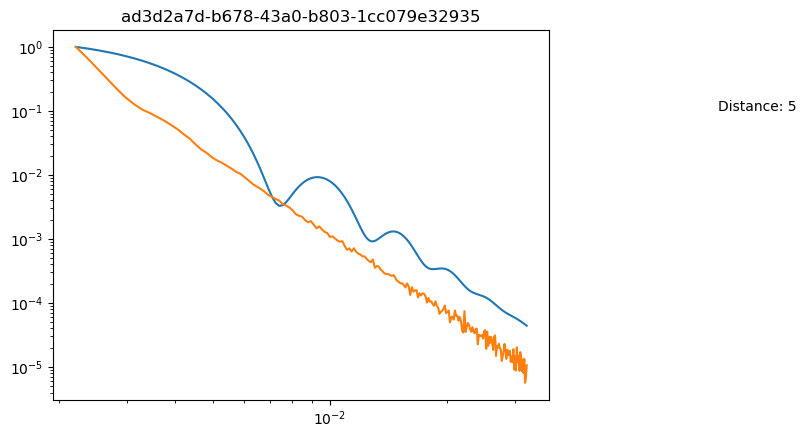

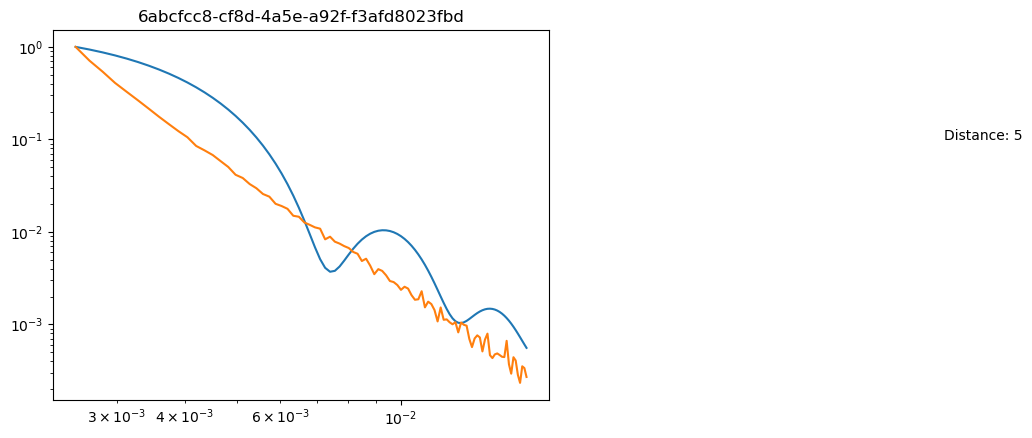

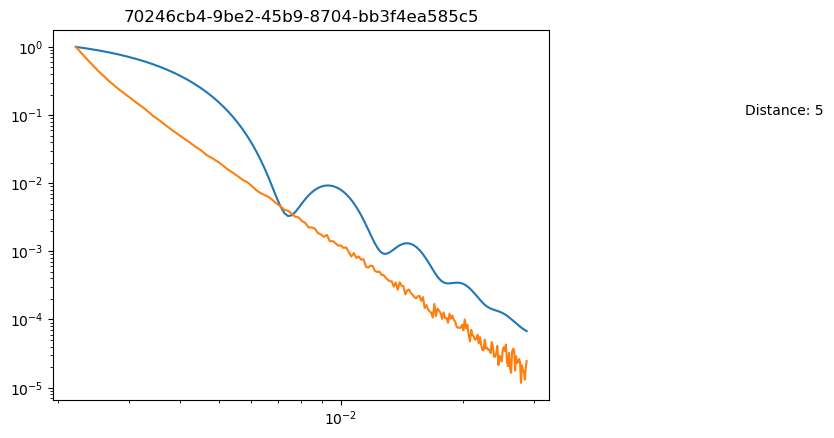

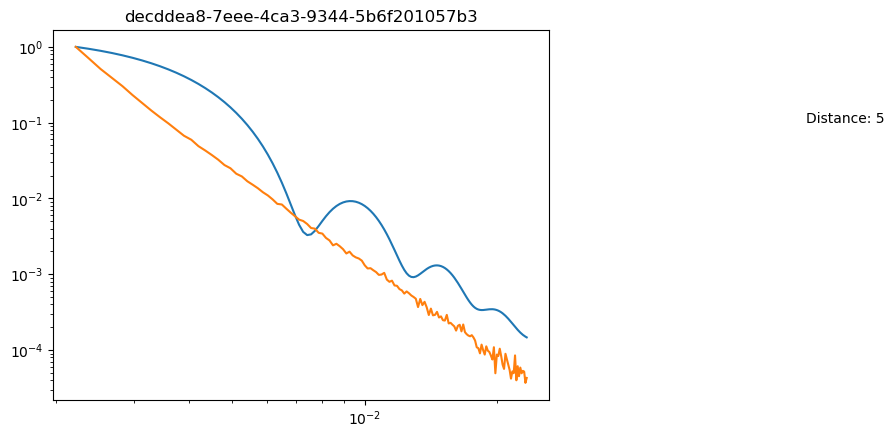

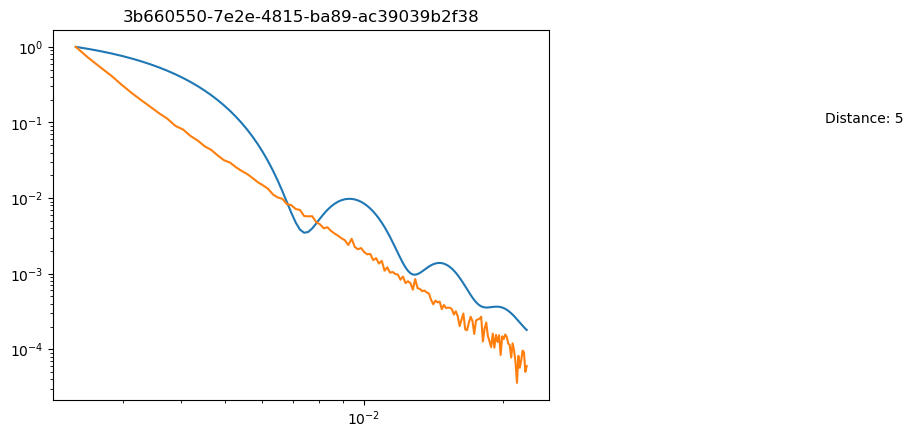

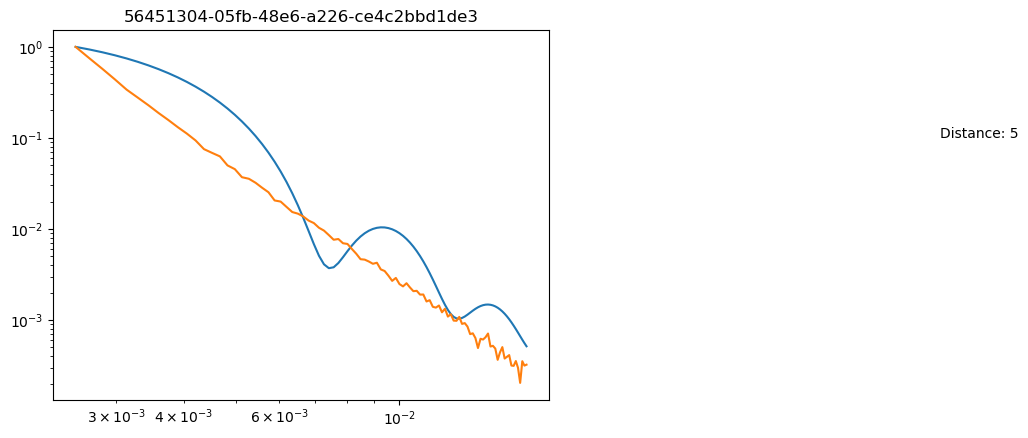

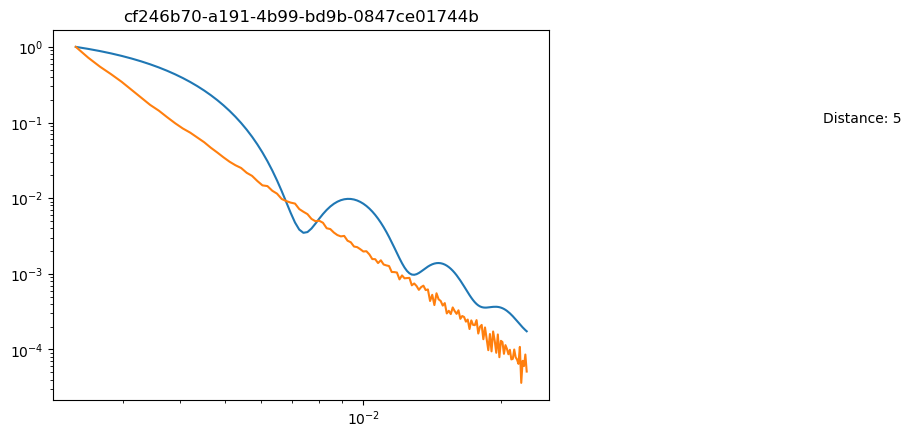

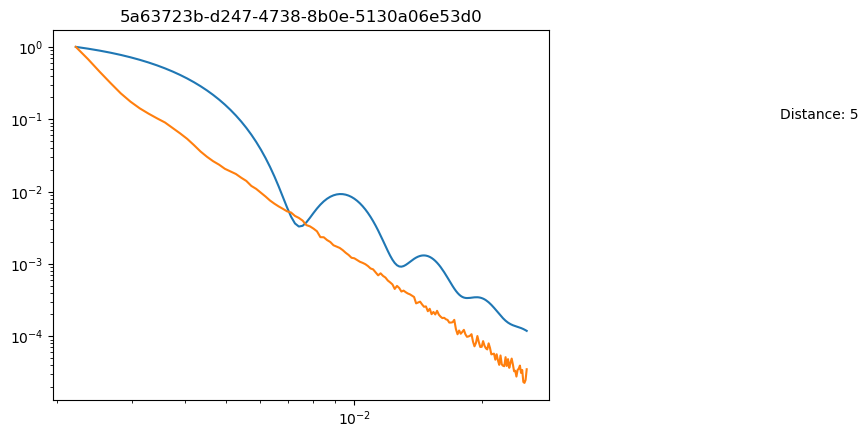

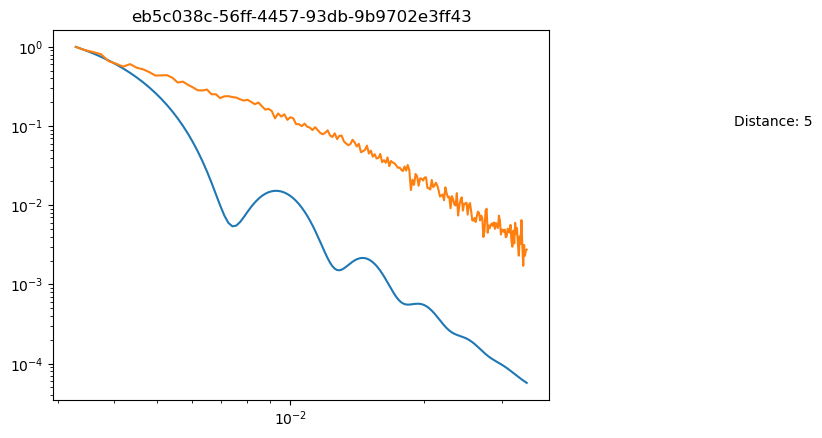

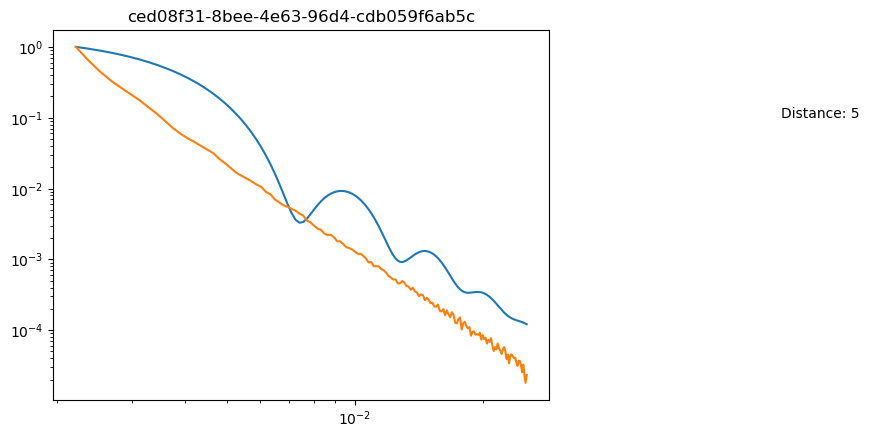

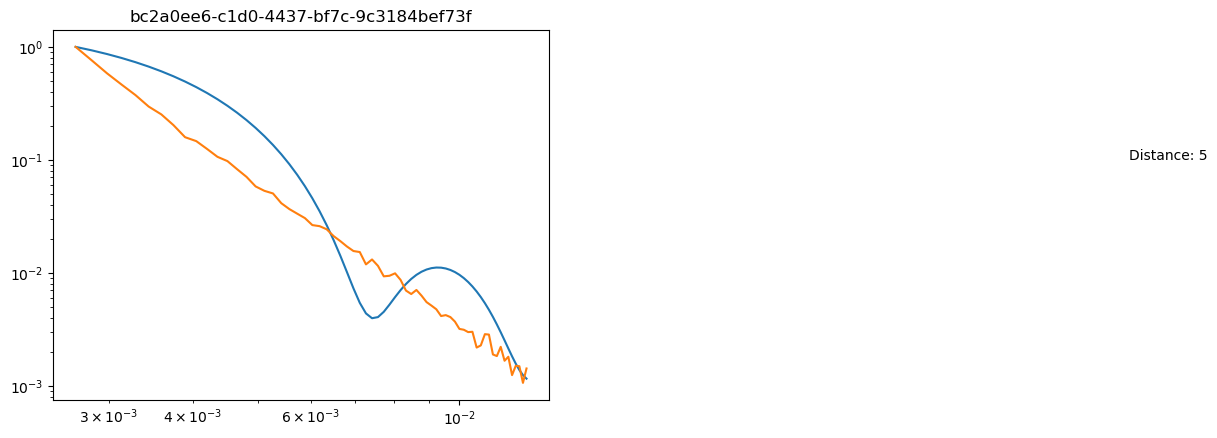

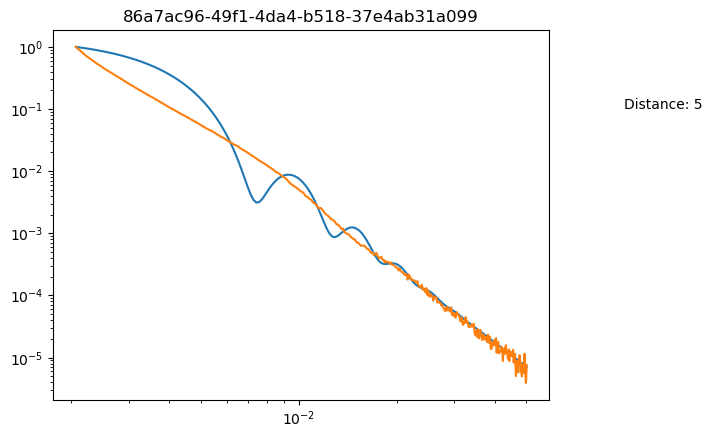

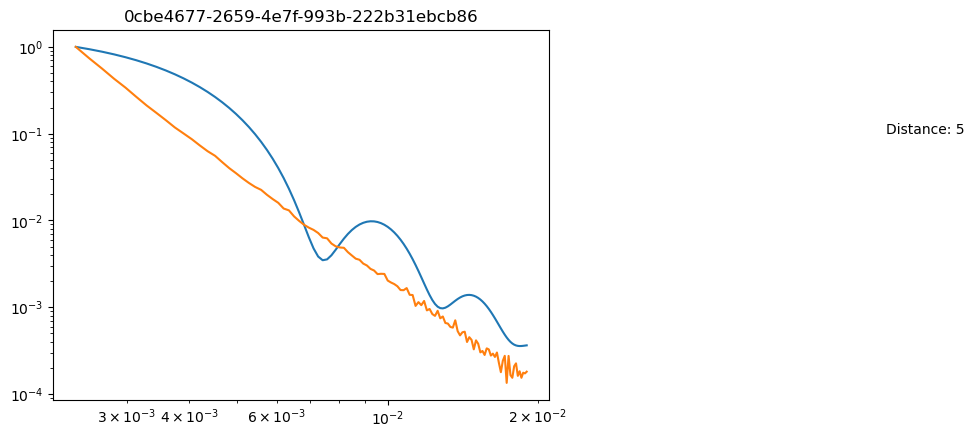

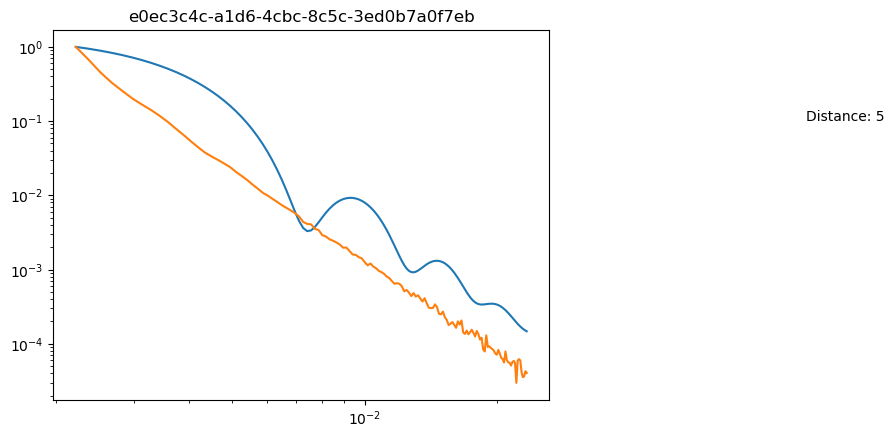

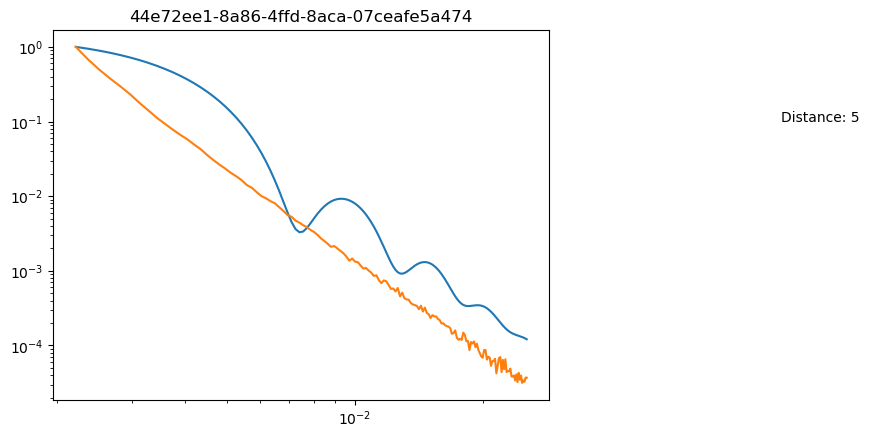

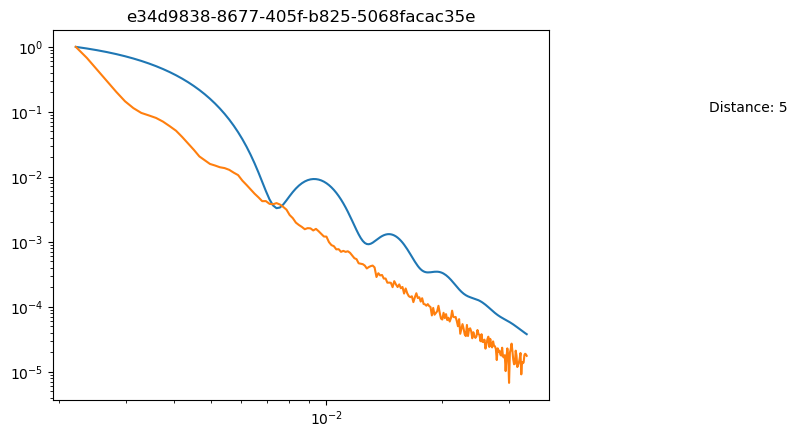

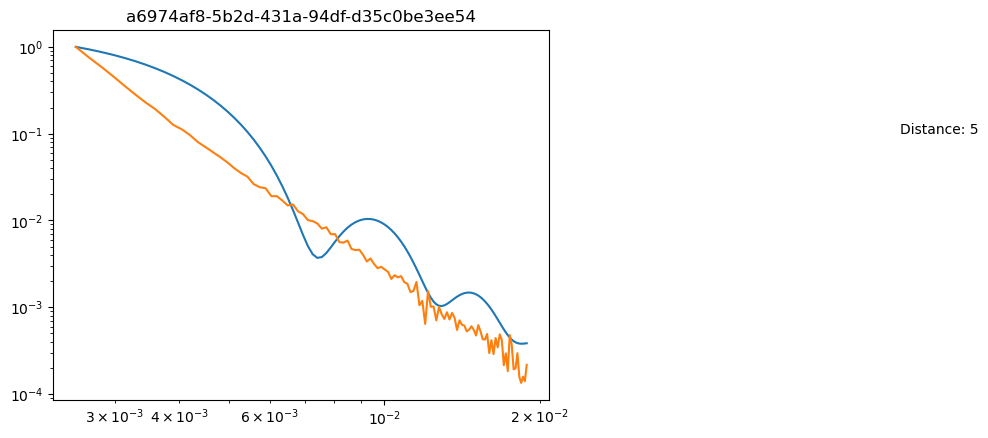

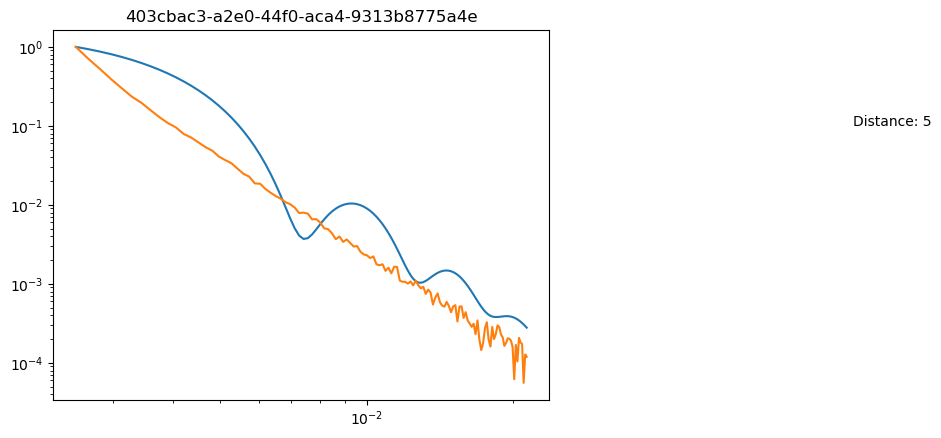

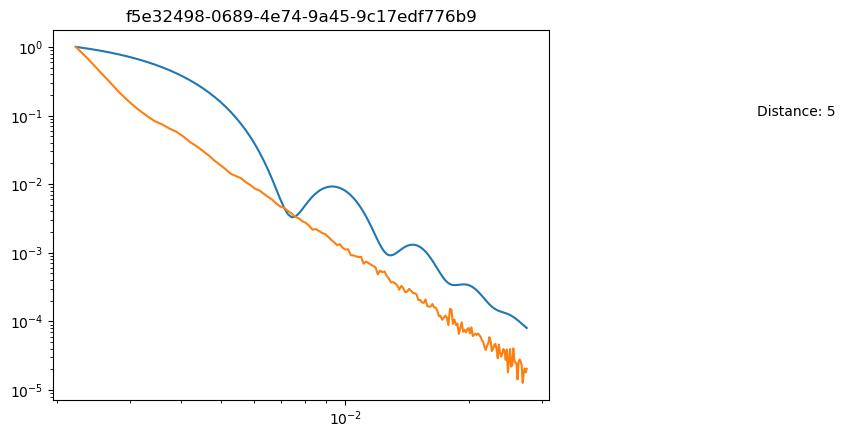

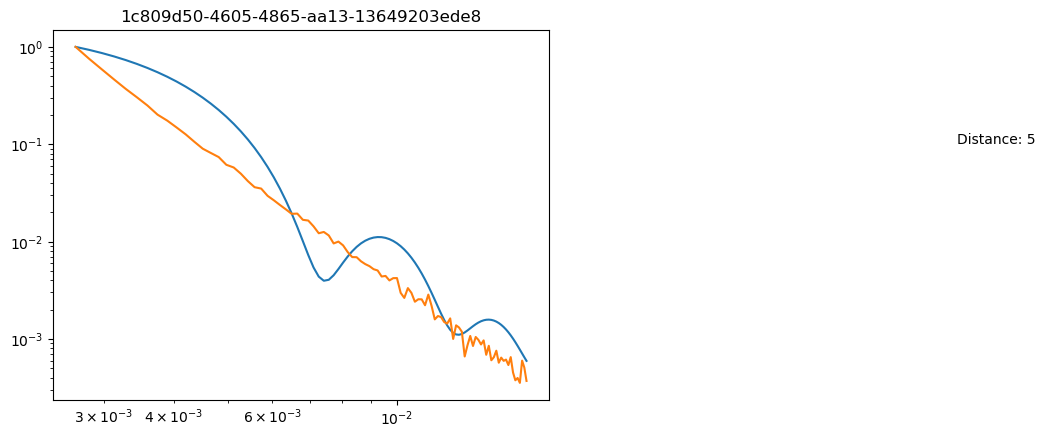

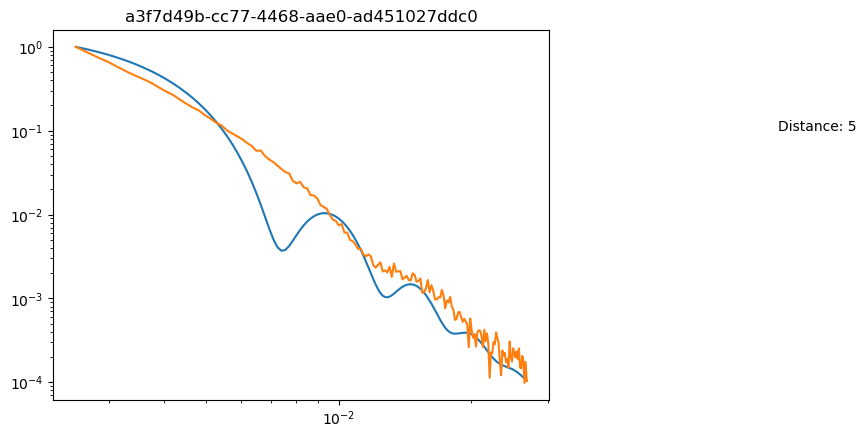

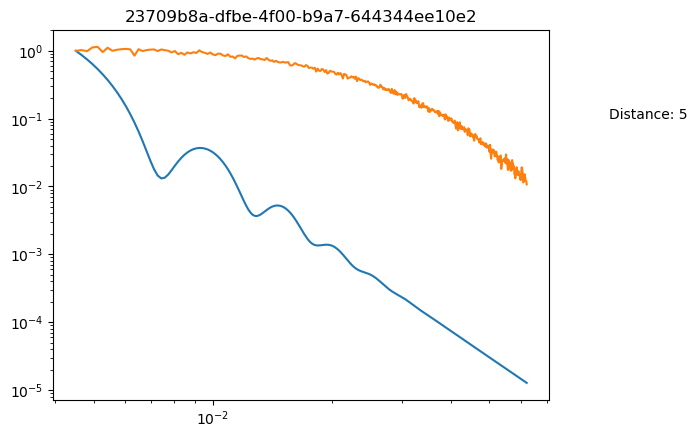

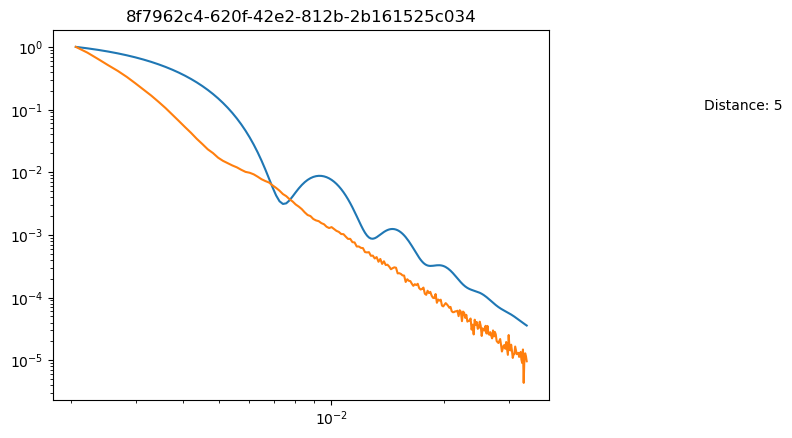

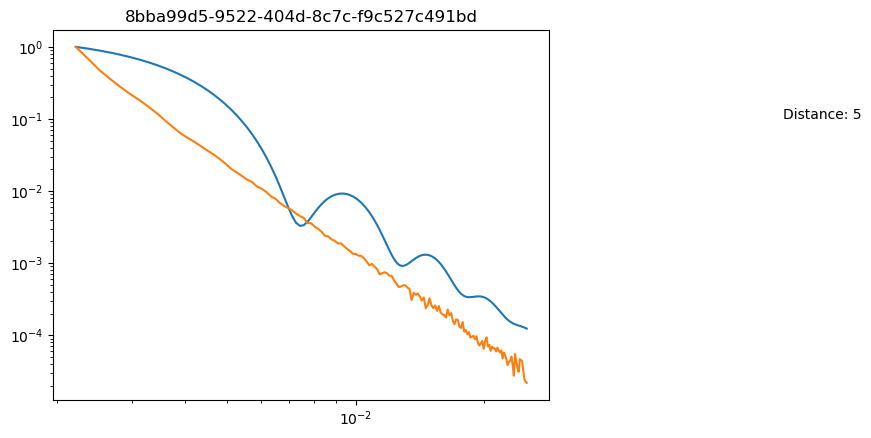

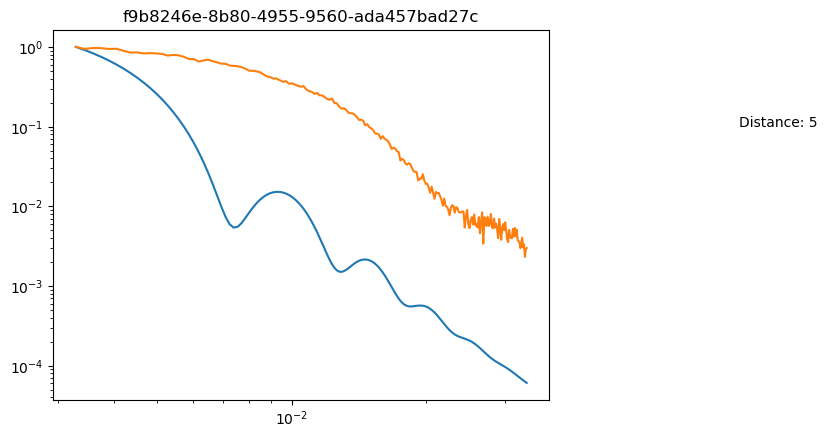

In [90]:
for uuid_val in uuid_sorted:
    try:
        data_val = subtracted_data[uuid_val]
    except KeyError:
        print(uuid_val)
        continue
    if data_val is None:
        continue
    else:
        meas_I = data_val['I'].to_numpy()
        q = data_val['q'].to_numpy()
        target_I = target_comparison.target_intensities(q, target_r_angs, target_pdi, sld_silica, sld_etoh)
        
        meas_norm = meas_I/(meas_I[0])
        target_norm = target_I/target_I[0]

        distance = distances[uuid_val]

        fig, ax = plt.subplots()
        ax.loglog(q, target_norm)
        ax.loglog(q, meas_norm)
        ax.set_title(uuid_val)
        ax.text(0.1, 0.1, f'Distance: {distance}')